In [20]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
from numpy import savetxt, loadtxt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy import matlib
import csv
from sklearn.manifold import TSNE
import matplotlib
import statsmodels
import sys
from statsmodels.formula.api import ols
import statsmodels.api as sm
import math
sys.path.append('/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering')

from cv_clustering.beta_aggregate import vector_mse, aggregate, predictargmax, subfold_mse, get_proba
from cv_clustering.utils import contingency_matrix, do_all_clus_corrs
from cv_clustering.loocv_assigmatcher_nov import get_co_cluster_count
from cv_clustering.multi_logr_bag import new_multiclassifCV

sys.path.append('/Users/lee_jollans/Projects/clustering_pilot/may2020_evaluation')
from utils_for_ipynb_050520 import *
from makedataframe import makedataframe


sets = ["Tc", "Sc", "TSc", "Tc_tc", "Sc_sc", "TSc_tsc", "Tct_s", "Scs_s", "Tct_Scs_s", "Tct_tc_s", "Scs_sc_s",
            "Tct_Scs_tc_sc_s"]
    
mdd_savedir = ('/Users/lee_jollans/Projects/clustering_pilot/FEB_PUT/FEB_')
all_savedir = ('/Users/lee_jollans/Projects/clustering_pilot/ALL/wspecsamp_')
mdd_datadir = ('/Users/lee_jollans/Projects/clustering_pilot/residfiles_all_210220/MDD__')


clin = pd.read_csv(r'/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/clin.csv');
clin.head()

ICV  consensusage_pheno  sex_pheno  site_pheno  scanstudy  bdi00  \
0  1335190                53.0          2           0          2    NaN   
1  1436170                48.0          2           0          2    NaN   
2  1580540                44.0          1           0          2    NaN   
3  1544460                63.0          1           0          2    NaN   
4  1382250                26.0          2           0          2    NaN   

   hmsum00  hmsummri  hmdi1_00  hmdi2_00  ...  hmdfu_8  hmdfu_9  hmdfu_10  \
0     19.0      19.0       2.0       1.0  ...      NaN      NaN       NaN   
1     32.0      32.0       4.0       2.0  ...      NaN      NaN       NaN   
2     23.0      23.0       2.0       1.0  ...      2.0      3.0       2.0   
3     24.0      24.0       3.0       1.0  ...      NaN      NaN       NaN   
4     19.0      19.0       4.0       0.0  ...      NaN      NaN       NaN   

   hmdfu_11  hmdfu_12  hmdfu_13  hmdfu_14  hmdfu_15  hmdfu_16  hmdfu_17  
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0  
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0  

[5 rows x 84 columns]

In [58]:
labels, df, all_testproba, mdd_testproba_ctrlresid, sampleidx, all_labelsmain2, mdd_ctrl_labelsmain2, all_probamain2,  \
            mdd_ctrl_probamain2, all_nsil, mdd_ctrl_nsil, studies, thick_all, surf_all, thick_mdd, surf_mdd =makedataframe() 

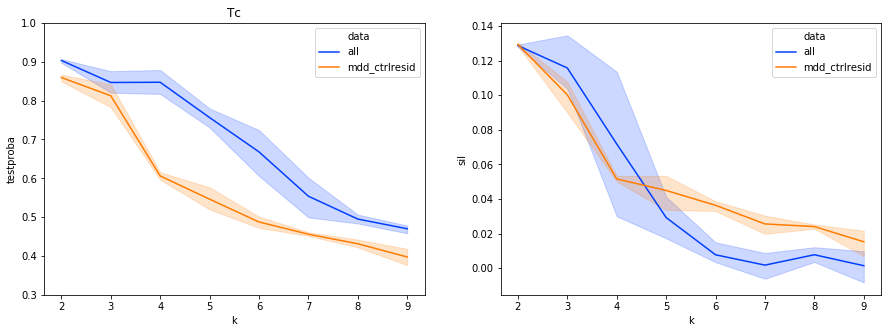

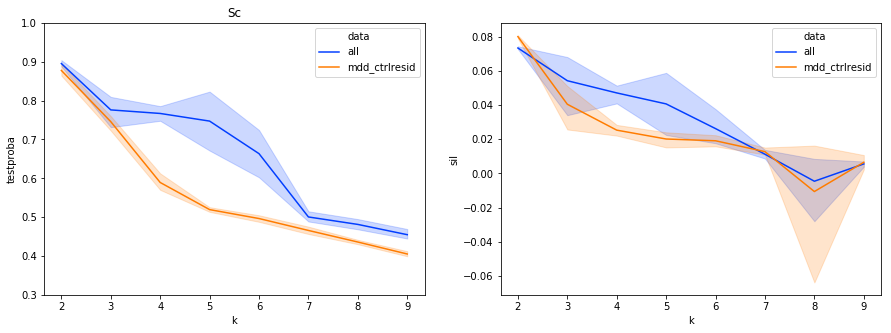

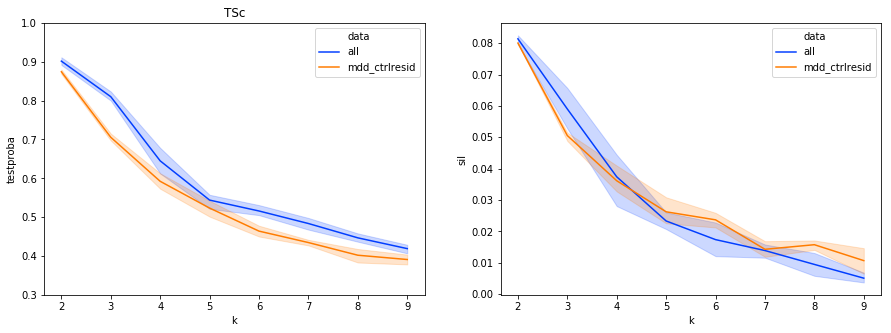

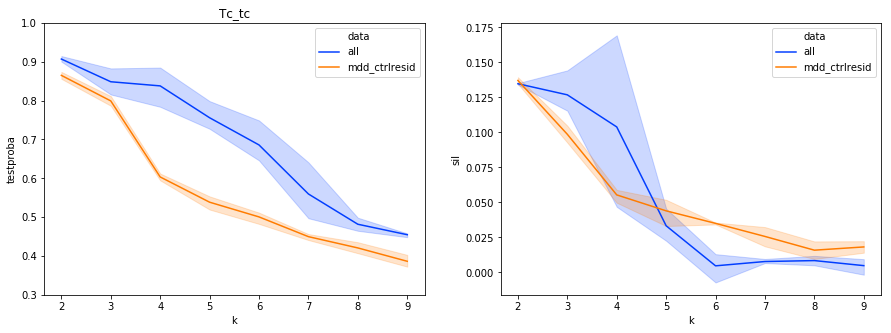

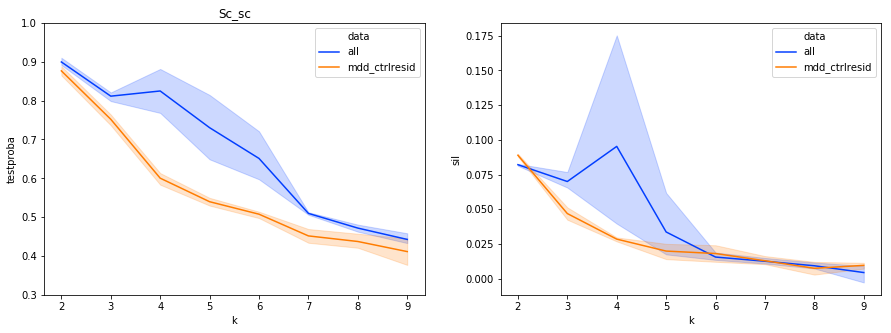

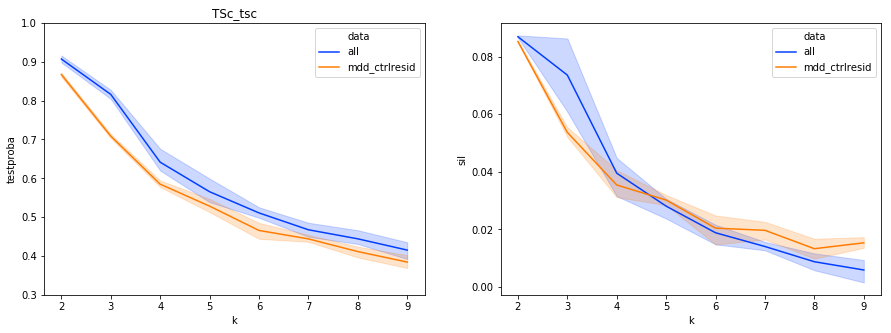

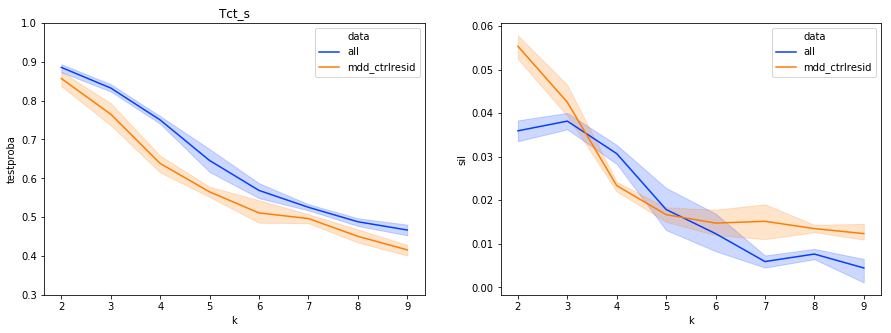

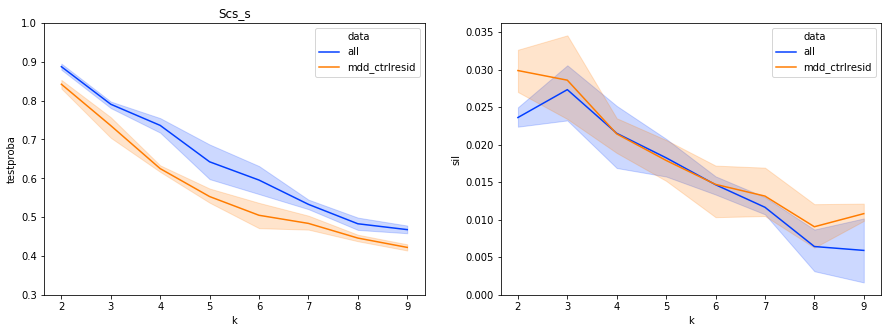

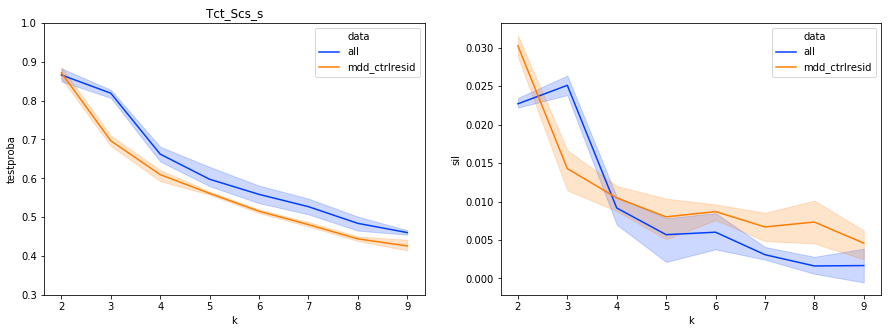

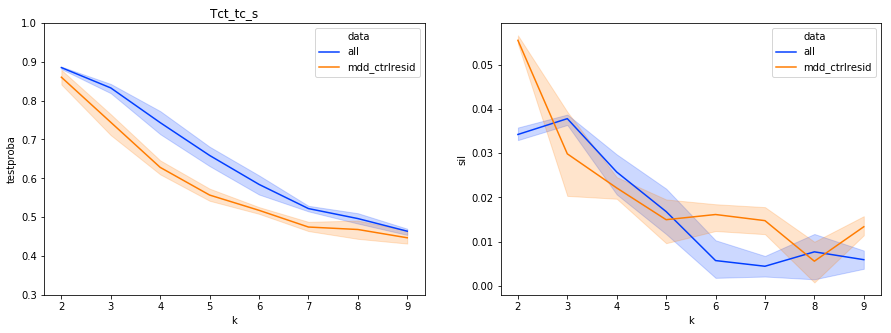

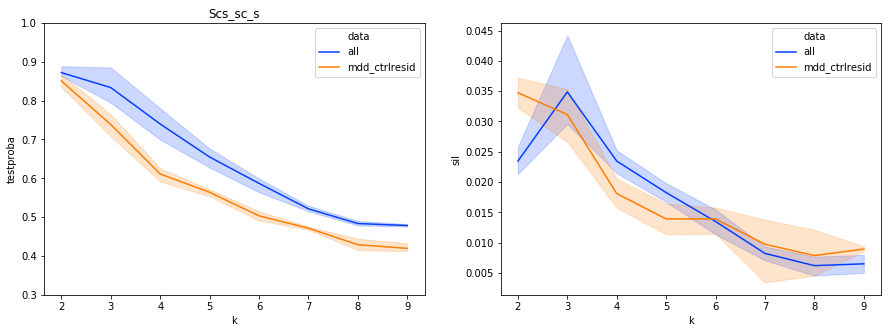

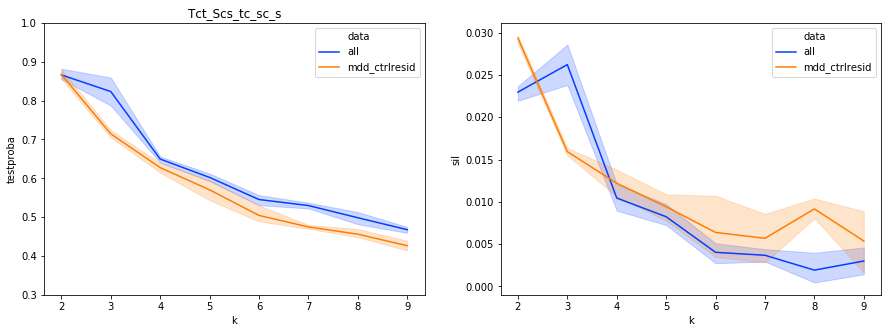

In [96]:
for s in range(12):
    fig = plt.figure(figsize=[15,5])
    df2=df[df['set']==sets[s]]
    plt.subplot(1,2,1)
    sns.lineplot(y='testproba',x='k',hue='data',data=df2, palette='bright')
    plt.ylim([0.3,1])
    plt.title(sets[s])
    plt.subplot(1,2,2)
    sns.lineplot(y='sil',x='k',hue='data',data=df2, palette='bright')
    plt.show()

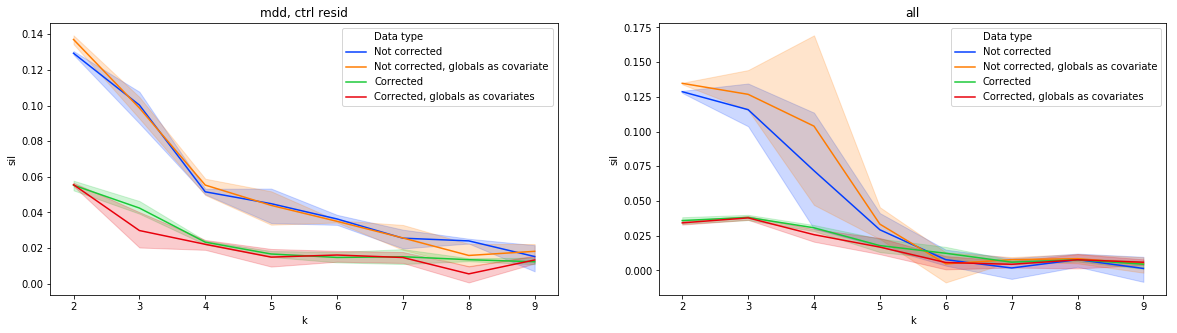

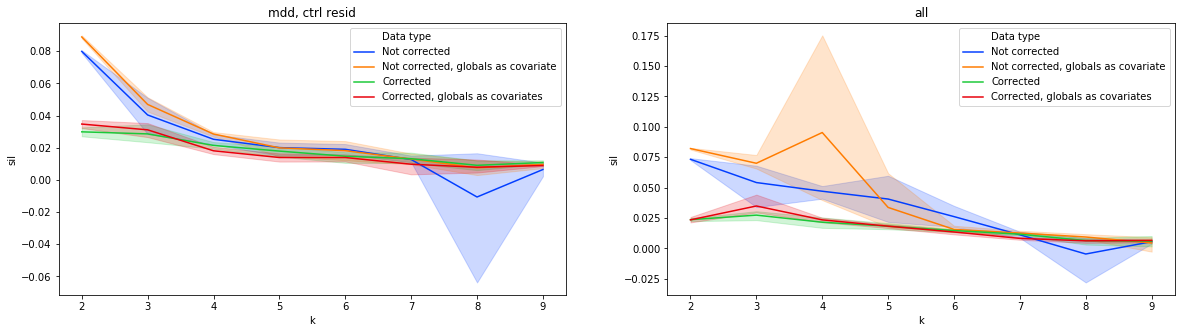

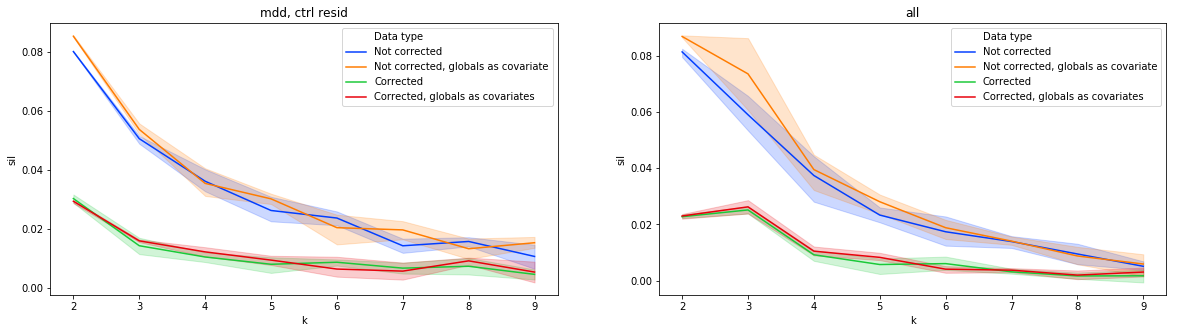

In [99]:
# plot all thickness lines
a=[0,3,6,9]
df3=df
df3['res_cov']=df3['res_cov'].replace({0:'Not corrected',1:'Not corrected, globals as covariate',2:'Corrected',3:'Corrected, globals as covariates'})
df3['Data type'] = df3['res_cov']
for mod in range(3):
    fig=plt.figure(figsize=[20,5])
    
    #plt.subplot(1,4,1); plt.title('mdd, ctrl resid'); plt.ylim([0.3,1])
    #df2=df[(df['mod']==mod) & (df['data']=='mdd_ctrlresid')]
    #sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')

    #plt.subplot(1,4,2); plt.title('all'); plt.ylim([0.3,1])
    #df2=df[(df['mod']==mod) & (df['data']=='all')]
    #sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')   
    
    plt.subplot(1,2,1); plt.title('mdd, ctrl resid'); 
    df2=df3[(df['mod']==mod) & (df3['data']=='mdd_ctrlresid')]
    sns.lineplot(y='sil',x='k',hue='Data type',data=df2, palette='bright')

    plt.subplot(1,2,2); plt.title('all'); 
    df2=df3[(df3['mod']==mod) & (df3['data']=='all')]
    sns.lineplot(y='sil',x='k',hue='Data type',data=df2, palette='bright')  
        
    plt.show()

In [81]:
def betamatch(MDDCTRLBETAS, labels2use, thresh=5):
    MDDCTRLallmses, r, r, r, r, r = subfold_mse(MDDCTRLBETAS)
    MDDCTRLallcorrs = do_all_clus_corrs(MDDCTRLBETAS,1)
    assignedwhere = check_clus_correspondence(MDDCTRLallcorrs,MDDCTRLallmses, thresh)
    print(assignedwhere)
    clusassig,balance,labelrecode=getassig(labels2use,assignedwhere)
    return clusassig

In [82]:
def pplotclussol(current_set, k_all, k_mdd, thresh=5, plotit=1):
    if current_set in [0,1,6,7]:
        nb=83
    elif current_set in [3,4,9,10]:
        nb=85
    else:
        print('supply number of features')
    # load aggregated beta weigths per CV fold

    mdd_ctrl_betas = np.full([nb,k_mdd,4],np.nan)
    all_betas = np.full([nb,k_all,4],np.nan)

    ALLBETAS = []
    MDDCTRLBETAS = []
    for mf in range(4):
        with open((mdd_savedir + sets[current_set] + '_aggregated_betas_k' + str(k_mdd-2) + '_ctrl_' + str(mf) + '.csv'), "r") as f:
            mdd_ctrl_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)
        with open((all_savedir + sets[current_set] + '_aggregated_betas_k' + str(k_all-2) + '_' + str(mf) + '.csv'), "r") as f:
            all_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)
        ALLBETAS.append(all_betas[:,:,mf])
        MDDCTRLBETAS.append(mdd_ctrl_betas[:,:,mf])

    # load data
    with open((mdd_datadir + sets[current_set] + '_ctrl.csv'), "r") as f:
        mdd_ctrl_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
    with open((all_savedir + sets[current_set] + '_ctrl.csv'), "r") as f:
        all_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)

    ALLallmses, r, r, r, r, r = subfold_mse(ALLBETAS)
    MDDCTRLallmses, r, r, r, r, r = subfold_mse(MDDCTRLBETAS)
    ALLallcorrs = do_all_clus_corrs(ALLBETAS,1)
    MDDCTRLallcorrs = do_all_clus_corrs(MDDCTRLBETAS,1)


    ###
    print('MDD')
    mdd_ctrl_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(mdd_ctrl_Tc)

    #clusassigmdd=match_by_perfectcoclu(mdd_ctrl_labelsmain2[:,current_set,k_mdd-2,:].T)
    #clusassigmdd=perfectmatch2(mdd_ctrl_labelsmain2[:,current_set,k_mdd-2,:].T, k_mdd)
    #clusassigmdd=match_by_agglom(mdd_ctrl_labelsmain2[:,current_set,k_mdd-2,:], k_mdd)
    clusassigmdd=betamatch(MDDCTRLBETAS, mdd_ctrl_labelsmain2[:,current_set,k_mdd-2,:], thresh)
    
    clin = pd.read_csv(r'/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/clin.csv');
    clin['assig']=clusassigmdd

    p=np.full(len(list(clin)),np.nan)
    for n in range(len(list(clin))-1):
        try:
            results = ols(list(clin)[n] + ' ~ C(assig)', data=clin).fit()
            aov_table = sm.stats.anova_lm(results, typ=2)
            p[n]=aov_table['PR(>F)'][0]
            if p[n]<.05:
                print('anova p=' + str(p[n]) + ' for ' + list(clin)[n])
        except:
            print('failed anova for' + list(clin)[n])

    if plotit==1:
        fig=plt.figure(figsize=[15,7])

        ax=plt.subplot(2,3,1)
        colorscatter(mdd_ctrl_tsne,np.array(clusassigmdd),np.ones(shape=[398,1])*4,ax,1)
        plt.xlabel('tsne1'); plt.ylabel('tsne2')
        ax=plt.subplot(2,3,2)
        colorscatter(mdd_ctrl_tsne,np.array(studies[:,1]).astype(int),np.ones(shape=[398,1])*4,ax,0)
        plt.legend(['not venla','venla'])
        plt.xlabel('tsne1'); plt.ylabel('tsne2')
        ax=plt.subplot(2,3,3)
        colorscatter(mdd_ctrl_tsne,np.array(studies[:,2]).astype(int),np.ones(shape=[398,1])*4,ax,0)
        plt.legend(['not gsk','gsk'])
        plt.xlabel('tsne1'); plt.ylabel('tsne2')

        ax=plt.subplot(2,3,4)
        colorscatter(thick_mdd,np.array(clusassigmdd),np.ones(shape=[398,1])*4,ax,1)
        plt.xlabel('left thickness'); plt.ylabel('right thickness')
        ax=plt.subplot(2,3,5)
        colorscatter(thick_mdd,np.array(studies[:,1]).astype(int),np.ones(shape=[398,1])*4,ax,0)
        plt.legend(['not venla','venla'])
        plt.xlabel('left thickness'); plt.ylabel('right thickness')
        ax=plt.subplot(2,3,6)
        colorscatter(thick_mdd,np.array(studies[:,2]).astype(int),np.ones(shape=[398,1])*4,ax,0)
        plt.legend(['not gsk','gsk'])
        plt.xlabel('left thickness'); plt.ylabel('right thickness')

        plt.show()

    ####
    print('ALL')
    all_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(all_Tc)

    #clusassigall=match_by_perfectcoclu(all_labelsmain2[:,current_set,k_all-2,:].T)
    #clusassigall=perfectmatch2(all_labelsmain2[:,current_set,k_all-2,:].T, k_all)
    #clusassigall=match_by_agglom(all_labelsmain2[:,current_set,k_all-2,:], k_all)
    clusassigall=betamatch(ALLBETAS, all_labelsmain2[:,current_set,k_all-2,:], thresh)
    
    clin = pd.read_csv('/Users/lee_jollans/Projects/clustering_pilot/ALL/ALL_covars.csv',header=None)
    clin.columns=['ICV','age','sex','site','age2']
    clin['assig']=clusassigall

    p=np.full(len(list(clin)),np.nan)
    for n in range(3):
        try:
            results = ols(list(clin)[n] + ' ~ C(assig)', data=clin).fit()
            aov_table = sm.stats.anova_lm(results, typ=2)
            p[n]=aov_table['PR(>F)'][0]
            if p[n]<.05:
                print('anova p=' + str(p[n]) + ' for ' + list(clin)[n])
        except:
            print('failed anova for' + list(clin)[n])
            
    if plotit==1:        
        fig=plt.figure(figsize=[10,7])

        ax=plt.subplot(2,2,1)
        colorscatter(all_tsne,np.array(clusassigall),np.ones(shape=[740,1])*4,ax,1)
        plt.xlabel('tsne1'); plt.ylabel('tsne2')
        ax=plt.subplot(2,2,2)
        colorscatter(all_tsne,sampleidx,np.ones(shape=[740,1])*4,ax,1)
        plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
        plt.xlabel('tsne1'); plt.ylabel('tsne2')

        ax=plt.subplot(2,2,3)
        colorscatter(thick_all,np.array(clusassigall),np.ones(shape=[740,1])*4,ax,1)
        plt.xlabel('left thickness'); plt.ylabel('right thickness')
        ax=plt.subplot(2,2,4)
        colorscatter(thick_all,sampleidx,np.ones(shape=[740,1])*4,ax,1)
        plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
        plt.xlabel('left thickness'); plt.ylabel('right thickness')

        plt.show()

    return clusassigmdd, clusassigall

MDD
[[1. 2. 0.]
 [0. 2. 0.]
 [2. 1. 0.]
 [0. 0. 0.]]
anova p=0.03796975463996757 for sex_pheno
anova p=0.0278008811215631 for site_pheno
anova p=1.2579101234789483e-05 for venla
anova p=1.0592902593989945e-07 for mridate
anova p=0.01415529698483722 for venla_u_date
anova p=0.042894168789971696 for hmdfu_2
anova p=0.012345805605062108 for hmdfu_3
anova p=0.004484049509031992 for hmdfu_4


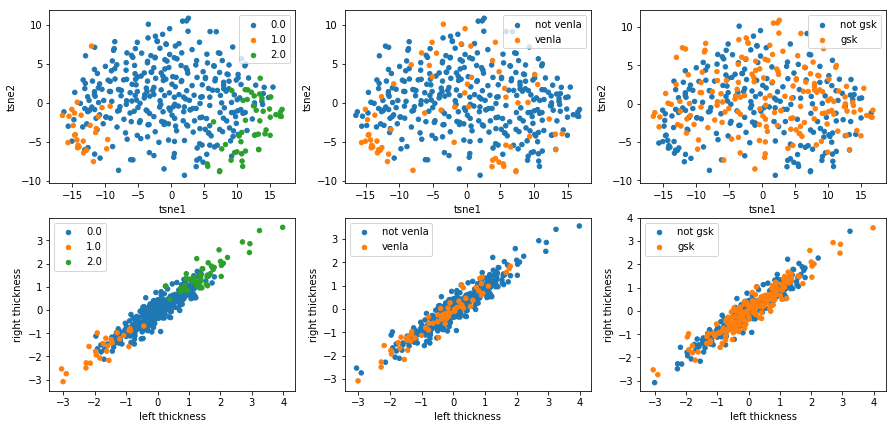

ALL
[[2. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 2. 1. 0.]
 [0. 1. 2. 0.]]


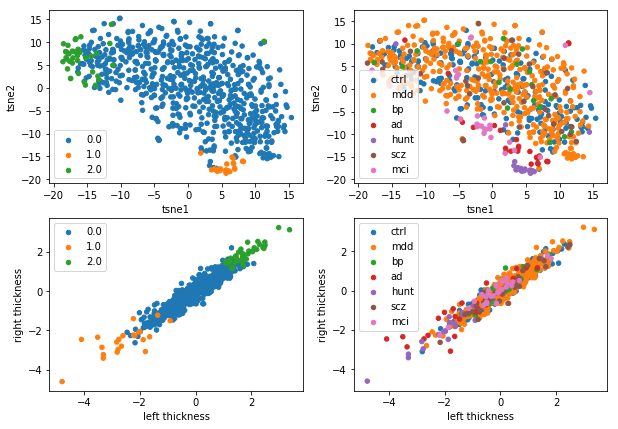

In [87]:
clusassigmdd, clusassigall = pplotclussol(0,4,3, 5,1)
savetxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_all_s0_c4.csv', clusassigall, delimiter=',', header='header')
savetxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_mddctrl_s0_c3.csv', clusassigmdd, delimiter=',', header='header')

MDD
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 2. 0.]
 [0. 2. 0.]]
anova p=2.109373327672329e-05 for site_pheno
anova p=0.02024867472787119 for hmsum00
anova p=0.017201049172327964 for hmdi1_00
anova p=0.024713515418946813 for hmdi2_00
anova p=0.02047013176658963 for hmdi3_00
anova p=0.01478833388569383 for hmdi20_00
anova p=0.006532285828516953 for hmdi20_mri
anova p=3.0506909974864622e-09 for venla
anova p=0.01251118875522374 for gsk
anova p=6.893061209391653e-08 for mridate
anova p=0.001281469928292588 for venla_u_date
anova p=0.007053341394649406 for hmdfu_11
anova p=0.006601364372481984 for hmdfu_12
anova p=0.006887550095206824 for hmdfu_13
anova p=0.007439276863766817 for hmdfu_14
anova p=0.01464103367290902 for hmdfu_15


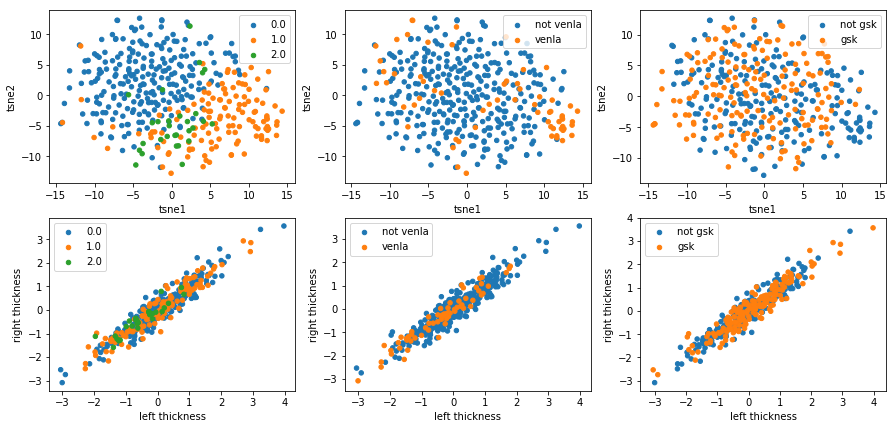

ALL
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
anova p=1.4413177770180906e-12 for age


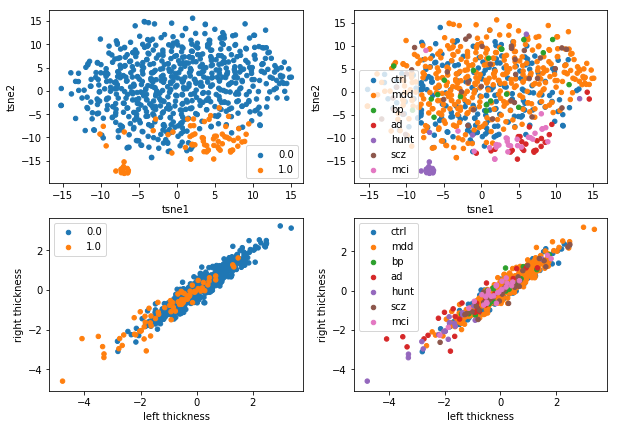

In [90]:
clusassigmdd, clusassigall = pplotclussol(6,3,3, 5,1)
savetxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_all_s6_c3.csv', clusassigall, delimiter=',', header='header')
savetxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_mddctrl_s6_c3.csv', clusassigmdd, delimiter=',', header='header')

MDD
[[0. 1. 0. 0. 2. 3. 4.]
 [4. 1. 0. 2. 5. 3. 0.]
 [1. 5. 0. 3. 3. 2. 0.]
 [1. 0. 0. 3. 0. 4. 0.]]
anova p=0.021970027020574823 for ICV
anova p=2.1416142389196835e-06 for site_pheno
anova p=0.014969451903144776 for mars
anova p=2.4350940772200985e-11 for venla
anova p=5.751254355444937e-12 for mridate
anova p=2.888403798672088e-06 for venla_u_date
anova p=0.041706188484854474 for hmdfu_4
anova p=0.0306066586645696 for hmdfu_10
anova p=0.0009362948338051734 for hmdfu_11
anova p=0.0011797284086140585 for hmdfu_12
anova p=0.0004991609942720731 for hmdfu_13
anova p=0.0001430355957938601 for hmdfu_14
anova p=0.0004483279919464959 for hmdfu_15
anova p=0.0024292470334698786 for hmdfu_17


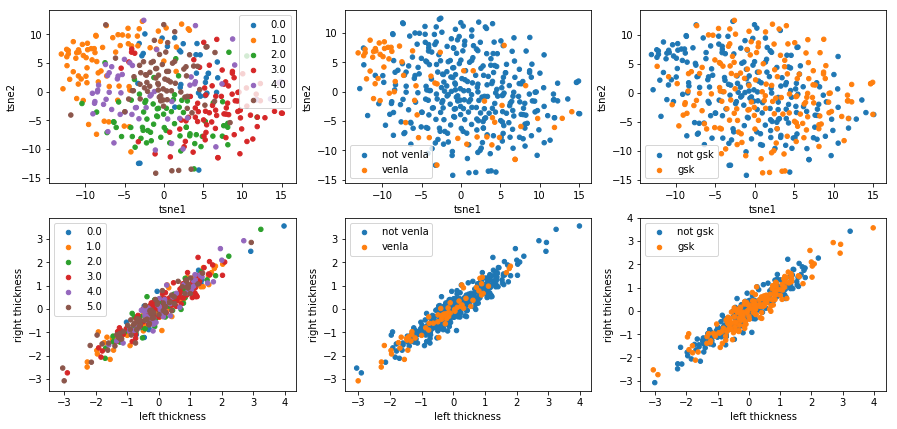

ALL
conflict!! 0 4 3 7
conflict!! 2 1 3 7
conflict!! 3 7 0 4
conflict!! 3 7 2 1
[[1. 0. 0. 0. 2. 0. 0. 3.]
 [2. 0. 3. 0. 0. 0. 0. 1.]
 [0. 2. 3. 4. 0. 0. 1. 0.]
 [2. 0. 3. 4. 0. 1. 0. 1.]]
anova p=0.0002706896152728501 for ICV
anova p=1.293931992397434e-10 for age
anova p=0.03622682940390245 for sex


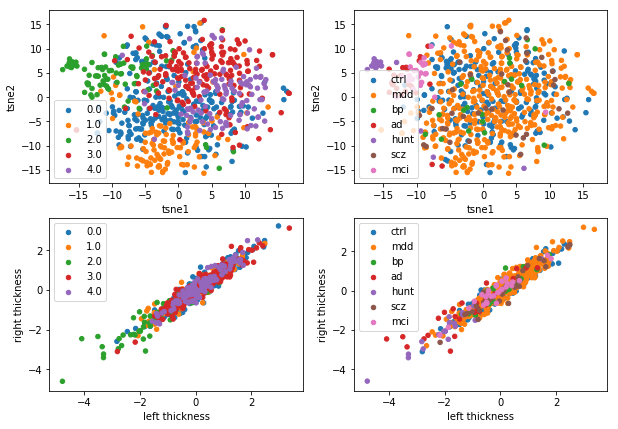

In [91]:
clusassigmdd, clusassigall = pplotclussol(6,8,7, 5,1)
savetxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_all_s6_c8.csv', clusassigall, delimiter=',', header='header')
savetxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_mddctrl_s6_c7.csv', clusassigmdd, delimiter=',', header='header')

In [144]:
clin = pd.read_csv(r'/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/clin.csv');

clusassigmdd=np.loadtxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_mddctrl_s0_c3.csv')
clin['assig']=clusassigmdd

clusassigmdd2=np.loadtxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_mddctrl_s6_c7.csv')
clin['assig2']=clusassigmdd2

clusassigmdd3=np.loadtxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_mddctrl_s6_c3.csv')
clin['assig3']=clusassigmdd3

Xinit = pd.read_csv(r'/Users/lee_jollans/Projects/MARS_GSK_project/data/alldatacollect/casedata.csv',header=None);
clin['brainage'] = np.vstack(Xinit.values[1:,162]).astype(np.float)
clin['brainPAD'] = np.vstack(Xinit.values[1:,157]).astype(np.float)-np.vstack(Xinit.values[1:,162]).astype(np.float)
print(list(clin))

hmbl=clin['hmsummri'].to_numpy()
hmfus=np.full([398,8],np.nan)
for n in range(8):
    hmfus[:,n]=clin['hmdfu_' + str(n+1)].to_numpy()
venla=clin['venla'].to_numpy()

df = pd.DataFrame({'sub': np.linspace(1,398,398),
                   'venla': clin['venla'],
                   'clus': clin['assig'],
                   'clus2': clin['assig2'],
                   'clus3': clin['assig3'],
                   'slope': clin['slope'],
                   'hmsum': clin['hmsum00'],
                   'week': np.full([398],0),
                  'brainPAD':clin['brainPAD']},
                  columns=['sub', 'venla', 'clus','clus2','clus3', 'slope','hmsum', 'week', 'brainPAD'])
for week in range(8):
    tmp_df = pd.DataFrame({'sub': np.linspace(1,398,398),
                           'venla': clin['venla'],
                           'clus': clin['assig'],
                           'clus2': clin['assig2'],
                           'clus3': clin['assig3'],
                           'slope': clin['slope'],
                           'hmsum': clin['hmdfu_' + str(week+1)],
                           'week': np.full([398],week+1),
                          'brainPAD':clin['brainPAD']},
                          columns=['sub', 'venla', 'clus','clus2', 'clus3','slope','hmsum', 'week', 'brainPAD'])
    df = df.append(tmp_df)
df.describe()

['ICV', 'consensusage_pheno', 'sex_pheno', 'site_pheno', 'scanstudy', 'bdi00', 'hmsum00', 'hmsummri', 'hmdi1_00', 'hmdi2_00', 'hmdi3_00', 'hmdi4_00', 'hmdi5_00', 'hmdi6_00', 'hmdi7_00', 'hmdi8_00', 'hmdi9_00', 'hmdi10_00', 'hmdi11_00', 'hmdi12_00', 'hmdi13_00', 'hmdi14_00', 'hmdi15_00', 'hmdi16_00', 'hmdi17_00', 'hmdi18_00', 'hmdi19_00', 'hmdi20_00', 'hmdi21_00', 'hmdi1_mri', 'hmdi2_mri', 'hmdi3_mri', 'hmdi4_mri', 'hmdi5_mri', 'hmdi6_mri', 'hmdi7_mri', 'hmdi8_mri', 'hmdi9_mri', 'hmdi10_mri', 'hmdi11_mri', 'hmdi12_mri', 'hmdi13_mri', 'hmdi14_mri', 'hmdi15_mri', 'hmdi16_mri', 'hmdi17_mri', 'hmdi18_mri', 'hmdi19_mri', 'hmdi20_mri', 'hmdi21_mri', 'firstep', 'k_psychot', 'sui', 'stai_aktuell', 'stai_habituell', 'HAMA_somatischeangst', 'HAMA_psychischeangst', 'mars', 'venla', 'gsk', 'slope', 'ind_slope', 'cluster', 'mridate', 'datum_00', 'u_date', 'venla_u_date', 'hmdfu_1', 'hmdfu_2', 'hmdfu_3', 'hmdfu_4', 'hmdfu_5', 'hmdfu_6', 'hmdfu_7', 'hmdfu_8', 'hmdfu_9', 'hmdfu_10', 'hmdfu_11', 'hmdfu_

sub        venla         clus        clus2        clus3  \
count  3582.000000  3582.000000  3582.000000  3582.000000  3582.000000   
mean    199.500000     0.160804     0.309045     2.713568     0.462312   
std     114.908382     0.367401     0.674440     1.575266     0.628027   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     100.000000     0.000000     0.000000     1.000000     0.000000   
50%     199.500000     0.000000     0.000000     3.000000     0.000000   
75%     299.000000     0.000000     0.000000     4.000000     1.000000   
max     398.000000     1.000000     2.000000     5.000000     2.000000   

             slope        hmsum         week     brainPAD  
count  1710.000000  1545.000000  3582.000000  2907.000000  
mean     -0.136352    16.700647     4.000000    -1.353746  
std       0.132651     7.316026     2.582349     8.690036  
min      -0.467462     0.000000     0.000000   -28.320000  
25%      -0.229702    12.000000     2.000000    -7.130000  
50%      -0.102806    16.000000     4.000000    -1.620000  
75%      -0.059577    22.000000     6.000000     4.550000  
max      -0.019847    41.000000     8.000000    30.640000

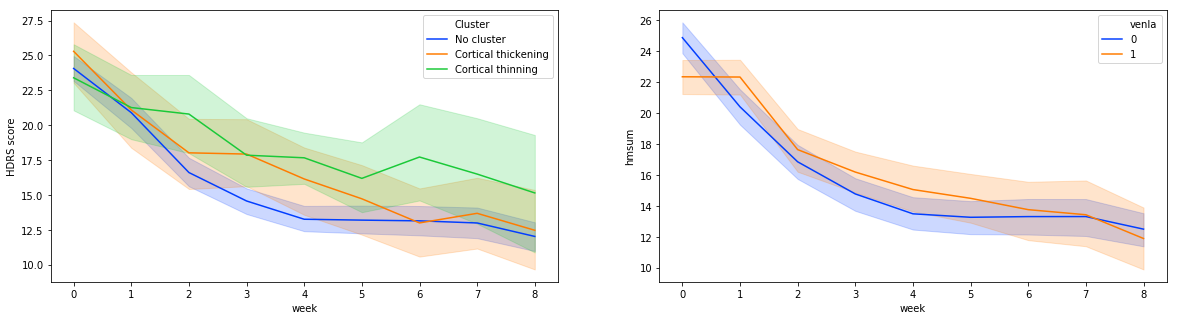

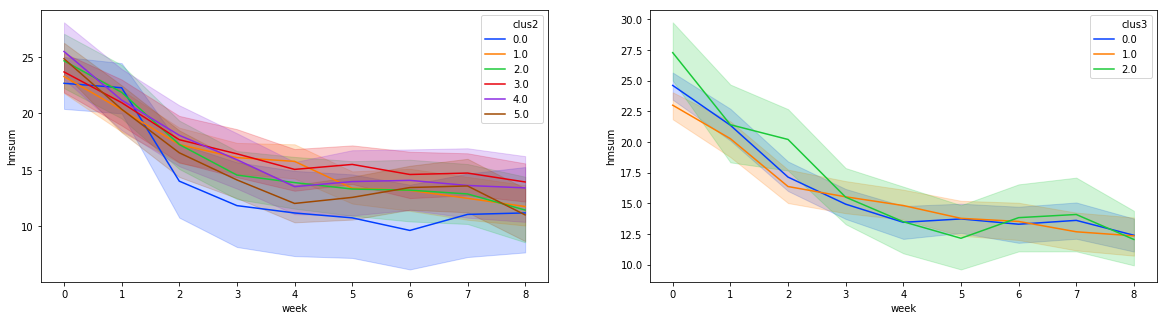

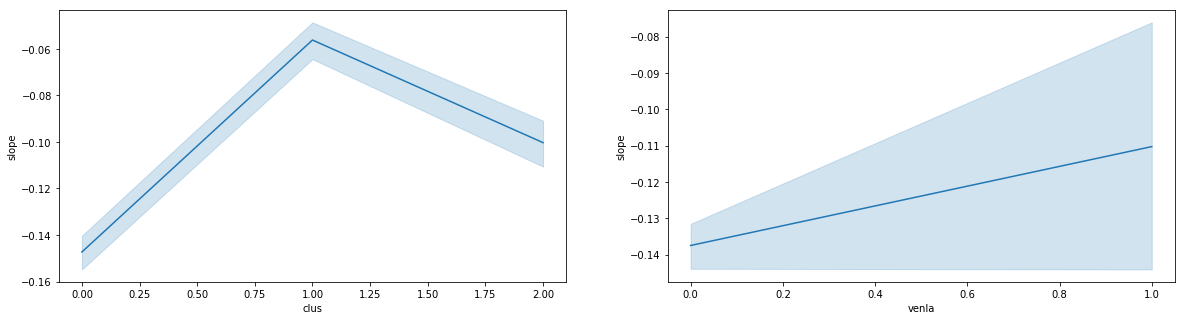

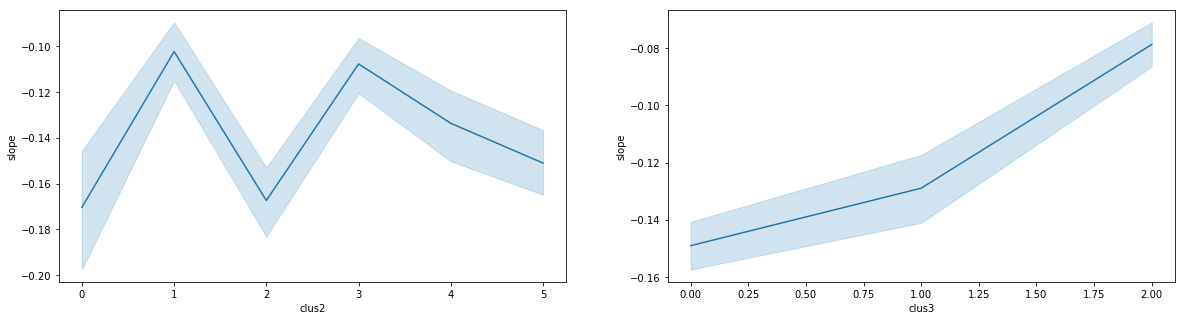

In [68]:
fig=plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
df2=df#[df['clus']!=2]
df2['Cluster']=df2['clus']
df2['HDRS score']=df2['hmsum']
df2['Cluster']=df2['Cluster'].replace({0:'No cluster',1:'Cortical thinning',2:'Cortical thickening'})
sns.lineplot(y='HDRS score',x='week',hue='Cluster',data=df2, palette='bright')
plt.subplot(1,2,2)
sns.lineplot(y='hmsum',x='week',hue='venla',data=df, palette='bright')
plt.show()

fig=plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
sns.lineplot(y='hmsum',x='week',hue='clus2',data=df, palette='bright')
plt.subplot(1,2,2)
sns.lineplot(y='hmsum',x='week',hue='clus3',data=df, palette='bright')
plt.show()

fig=plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
sns.lineplot(y='slope',x='clus',data=df, palette='bright')
plt.subplot(1,2,2)
sns.lineplot(y='slope',x='venla',data=df, palette='bright')
plt.show()

fig=plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
sns.lineplot(y='slope',x='clus2',data=df, palette='bright')
plt.subplot(1,2,2)
sns.lineplot(y='slope',x='clus3',data=df, palette='bright')
plt.show()

(2, 398)


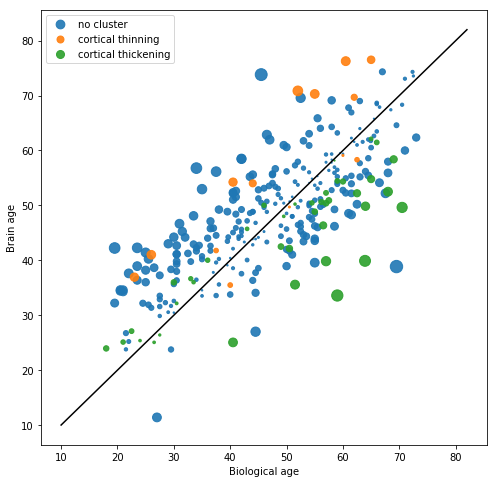

In [257]:
X=np.array([clin['consensusage_pheno'].to_numpy(),clin['brainage'].to_numpy()])
print(X.shape)
fig=plt.figure(figsize=[8,8]); ax1=plt.subplot(1,1,1)
colorscatter(X.T, clusassigmdd, abs(clin['brainPAD'].to_numpy()),ax1,0, aa=0.9, mm='o')
plt.legend(['no cluster','cortical thinning','cortical thickening'])
x=np.linspace(10,82,72)
plt.plot(x,x,'k-')
plt.xlabel('Biological age')
plt.ylabel('Brain age')
plt.show()

In [36]:
conmat1 = contingency_matrix(clusassigmdd, clusassigmdd2)
print(conmat1)
conmat2 = contingency_matrix(clusassigmdd, clusassigmdd3)
print(conmat2)
conmat3 = contingency_matrix(clusassigmdd3, clusassigmdd2)
print(conmat3)
conmat4 = contingency_matrix(clin['venla'], clusassigmdd)
print(conmat4)


[[28 40 69 73 48 65]
 [ 0 17  1  2  1  6]
 [ 4 19  2 12  7  4]]
[[215  80  28]
 [  7  20   0]
 [ 21  26   1]]
[[18  1 68 85 42 29]
 [11 75  3  2 14 21]
 [ 3  0  1  0  0 25]]
[[279  14  41]
 [ 44  13   7]]


In [60]:
print(np.sum(conmat1,axis=1))
print(np.sum(conmat1,axis=0))
print(np.sum(conmat4,axis=1))
print(np.sum(conmat4,axis=0))
print('s6 c8 props')
print(1700/27)
print(1900/48)
print('s6 c3 props')
print(2000/27)
print(2600/48)
print('venla props')
print(1300/64)
print(700/64)
print(1300/27)
clin[clin['assig']==1][['gsk', 'mars','venla', 'firstep']]
print(clin.groupby('assig')['firstep'].sum())
print(clin.groupby('assig')['venla'].sum())
print(clin.groupby('assig')['gsk'].sum())

[323  27  48]
[32 76 72 87 56 75]
[334  64]
[323  27  48]
s6 c8 props
62.96296296296296
39.583333333333336
s6 c3 props
74.07407407407408
54.166666666666664
venla props
20.3125
10.9375
48.148148148148145
assig
0.0    89.0
1.0     6.0
2.0    16.0
Name: firstep, dtype: float64
assig
0.0    44
1.0    13
2.0     7
Name: venla, dtype: int64
assig
0.0    144
1.0      9
2.0     19
Name: gsk, dtype: int64


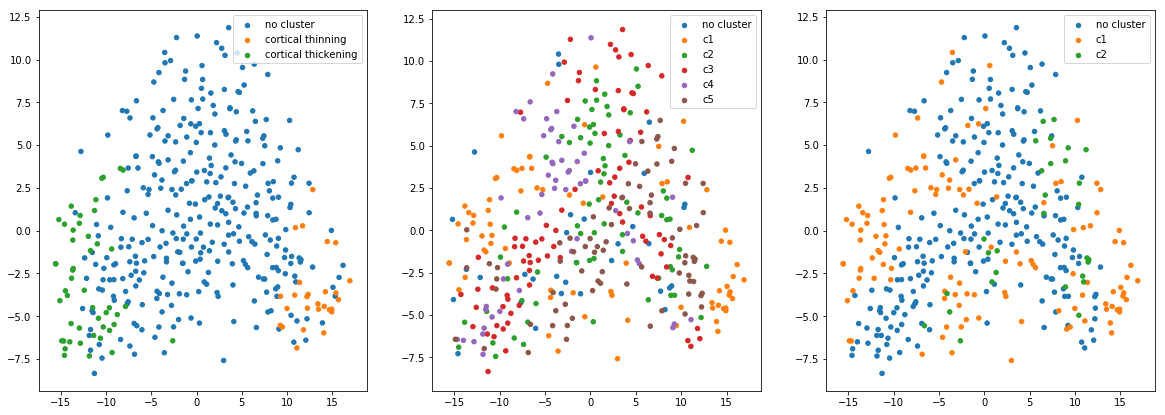

In [260]:
with open((mdd_datadir + sets[0] + '_ctrl.csv'), "r") as f:
    mdd_ctrl_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
mdd_ctrl_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(mdd_ctrl_Tc)

fig=plt.figure(figsize=[20,7])
ax1=plt.subplot(1,3,1); colorscatter(mdd_ctrl_tsne, clusassigmdd, np.ones(398)*4, ax1); plt.legend(['no cluster', 'cortical thinning', 'cortical thickening'])
ax2=plt.subplot(1,3,2); colorscatter(mdd_ctrl_tsne, clusassigmdd2, np.ones(398)*4, ax2); plt.legend(['no cluster', 'c1','c2','c3','c4','c5','c6' ])
ax3=plt.subplot(1,3,3); colorscatter(mdd_ctrl_tsne, clusassigmdd3, np.ones(398)*4, ax3); plt.legend(['no cluster', 'c1','c2'])
plt.show()

(2, 398)


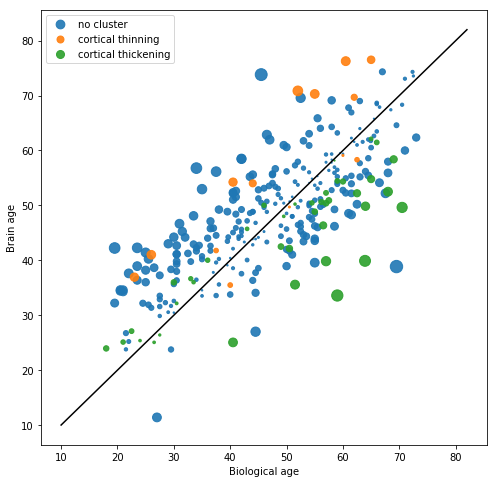

In [261]:
X=np.array([clin['consensusage_pheno'].to_numpy(),clin['brainage'].to_numpy()])
print(X.shape)
fig=plt.figure(figsize=[8,8]); ax1=plt.subplot(1,1,1)
colorscatter(X.T, clusassigmdd, abs(clin['brainPAD'].to_numpy()),ax1,0, aa=0.9, mm='o')
plt.legend(['no cluster','cortical thinning','cortical thickening'])
x=np.linspace(10,82,72)
plt.plot(x,x,'k-')
plt.xlabel('Biological age')
plt.ylabel('Brain age')
plt.show()

In [262]:
a1=clin['brainPAD'].to_numpy()
a2=clin['hmdfu_2'].to_numpy()
a1 = np.delete(a1, np.where(np.isnan(a2))[0])
a2 = np.delete(a2, np.where(np.isnan(a2))[0])
a2 = np.delete(a2, np.where(np.isnan(a1))[0])
a1 = np.delete(a1, np.where(np.isnan(a1))[0])
np.corrcoef(a1,a2)

array([[1.        , 0.07171677],
       [0.07171677, 1.        ]])

(2, 398)


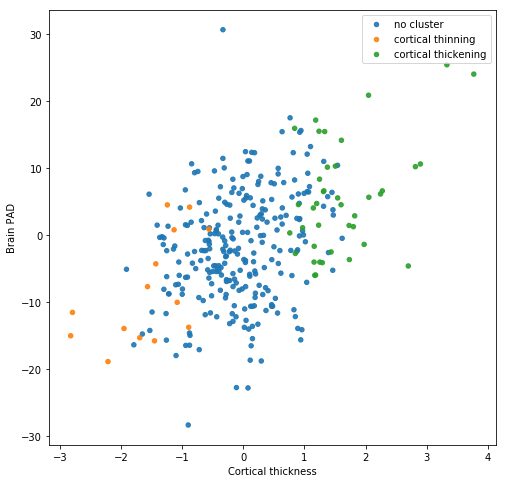

In [263]:
X=np.array([np.mean(thick_mdd,axis=1).T,clin['brainPAD'].to_numpy()])
print(X.shape)
fig=plt.figure(figsize=[8,8]); ax1=plt.subplot(1,1,1)
colorscatter(X.T, clusassigmdd, np.ones(398)*4,ax1,0, aa=0.9, mm='o')
plt.legend(['no cluster','cortical thinning','cortical thickening'])
plt.xlabel('Cortical thickness')
plt.ylabel('Brain PAD')
plt.show()

In [162]:
def corrwithnans(a1,a2):
    a1 = np.delete(a1, np.where(np.isnan(a2))[0])
    a2 = np.delete(a2, np.where(np.isnan(a2))[0])
    a2 = np.delete(a2, np.where(np.isnan(a1))[0])
    a1 = np.delete(a1, np.where(np.isnan(a1))[0])
    print('N=' + str(len(a1)) + ', r=' + str(np.corrcoef(a1,a2)[0,1]))

In [163]:
a1=clin['brainPAD'].to_numpy()
a2=np.mean(thick_mdd,axis=1)
corrwithnans(a1,a2)

N=323, r=0.44376767413359025


In [265]:
clin12=clin[(clin['assig']>0)]
clin12.describe()

ICV  consensusage_pheno  sex_pheno  site_pheno  scanstudy  \
count  7.500000e+01           75.000000  75.000000   75.000000  75.000000   
mean   1.511681e+06           48.340000   1.413333    0.586667   1.760000   
std    1.565655e+05           14.197063   0.495748    0.495748   1.050611   
min    1.127270e+06           18.000000   1.000000    0.000000  -1.000000   
25%    1.420305e+06           38.750000   1.000000    0.000000   1.000000   
50%    1.487240e+06           51.500000   1.000000    1.000000   2.000000   
75%    1.592385e+06           59.500000   2.000000    1.000000   3.000000   
max    1.919600e+06           72.000000   2.000000    1.000000   3.000000   

           bdi00    hmsum00   hmsummri   hmdi1_00   hmdi2_00  ...   hmdfu_13  \
count  20.000000  42.000000  42.000000  42.000000  42.000000  ...  27.000000   
mean   12.150000  24.619048  21.011905   3.142857   1.428571  ...   4.925926   
std    10.059167   5.499234   6.635536   0.951800   0.769633  ...   8.561658   
min     0.000000  14.000000   3.000000   1.000000   0.000000  ...   0.000000   
25%     5.000000  21.000000  17.250000   2.000000   1.000000  ...   0.000000   
50%     9.000000  23.500000  21.000000   3.000000   2.000000  ...   0.000000   
75%    19.250000  28.750000  24.750000   4.000000   2.000000  ...   6.500000   
max    32.000000  36.000000  35.000000   4.000000   3.000000  ...  24.000000   

        hmdfu_14   hmdfu_15   hmdfu_16   hmdfu_17      assig     assig2  \
count  24.000000  25.000000  20.000000  21.000000  75.000000  75.000000   
mean    3.062500   3.160000   0.450000   2.809524   1.640000   2.213333   
std     7.025284   6.536309   2.012461   7.393369   0.483232   1.579372   
min     0.000000   0.000000   0.000000   0.000000   1.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   1.000000   1.000000   
50%     0.000000   0.000000   0.000000   0.000000   2.000000   1.000000   
75%     0.000000   0.000000   0.000000   0.000000   2.000000   3.000000   
max    23.000000  22.000000   9.000000  27.000000   2.000000   5.000000   

          assig3   brainage   brainPAD  
count  75.000000  54.000000  54.000000  
mean    0.640000  47.008889   1.946667  
std     0.510432  13.326243  10.160236  
min     0.000000  23.950000 -18.860000  
25%     0.000000  36.720000  -4.087500  
50%     1.000000  49.670000   1.465000  
75%     1.000000  54.322500   6.600000  
max     2.000000  76.520000  25.410000  

[8 rows x 89 columns]

In [83]:
def anovas1(chk='hmsummri'):
    
    results = ols(chk + ' ~ C(venla)', data=clin).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('venla: p =', aov_table['PR(>F)'][0])
    #print(aov_table)
    
    results = ols(chk + ' ~ C(assig)', data=clin).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('cluster 1, 2, or none: p =', aov_table['PR(>F)'][0])
    #print(aov_table)
    
    clin_tmp = clin[clin['assig'] != 0]
    results = ols(chk + ' ~ C(assig)', data=clin_tmp).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('cluster 1 or 2: p =', aov_table['PR(>F)'][0])
    #print(aov_table)
    
    clin_tmp = clin[clin['assig'] != 2]
    results = ols(chk + ' ~ C(assig)', data=clin_tmp).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('cluster 1 or none: p =', aov_table['PR(>F)'][0])
    #print(aov_table)
    
    clin_tmp = clin[clin['assig'] != 1]
    results = ols(chk + ' ~ C(assig)', data=clin_tmp).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('cluster 2 or none: p =', aov_table['PR(>F)'][0])
    ##print(aov_table)
    
    clin_tmp = clin
    clin_tmp['nassig']=clin_tmp['assig']
    clin_tmp['nassig']=clin_tmp['nassig'].replace(2,1)
    results = ols(chk + ' ~ C(nassig)', data=clin_tmp).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('cluster 1/2 or none: p =', aov_table['PR(>F)'][0])
    #print(aov_table)
    
    results = ols(chk + ' ~ C(assig2)', data=clin).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('set 6 7cluster : p =', aov_table['PR(>F)'][0])
    #print(aov_table)
    
    results = ols(chk + ' ~ C(assig3)', data=clin).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('s6 cluster 1, 2, or none: p =', aov_table['PR(>F)'][0])
    #print(aov_table)
    
    clin_tmp = clin[clin['assig3'] != 0]
    results = ols(chk + ' ~ C(assig3)', data=clin_tmp).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('s6 cluster 1 or 2: p =', aov_table['PR(>F)'][0])
    #print(aov_table)
    
    clin_tmp = clin[clin['assig3'] != 2]
    results = ols(chk + ' ~ C(assig3)', data=clin_tmp).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('s6 cluster 1 or none: p =', aov_table['PR(>F)'][0])
    #print(aov_table)
    
    clin_tmp = clin[clin['assig3'] != 1]
    results = ols(chk + ' ~ C(assig3)', data=clin_tmp).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('s6 cluster 2 or none: p =', aov_table['PR(>F)'][0])
    ##print(aov_table)
    
    clin_tmp = clin
    clin_tmp['nassig']=clin_tmp['assig3']
    clin_tmp['nassig']=clin_tmp['nassig'].replace(2,1)
    results = ols(chk + ' ~ C(nassig)', data=clin_tmp).fit()
    aov_table = sm.stats.anova_lm(results, typ=2)
    if aov_table['PR(>F)'][0]<.05:
        print('s6 cluster 1/2 or none: p =', aov_table['PR(>F)'][0])
    #print(aov_table)

In [84]:
anovas1(chk='hmsummri')

In [85]:
anovas1(chk='hmdfu_2')

cluster 1, 2, or none: p = 0.042894168789971696
cluster 1 or none: p = 0.01710814904652525
cluster 1/2 or none: p = 0.031136838473039066
s6 cluster 1 or 2: p = 0.030897752019286427


In [86]:
anovas1(chk='hmdfu_4')

cluster 1, 2, or none: p = 0.004484049509031992
cluster 1 or none: p = 0.005654207582888358
cluster 2 or none: p = 0.04265059248967511
cluster 1/2 or none: p = 0.001363445428400525
set 6 7cluster : p = 0.041706188484854474


In [87]:
anovas1(chk='hmdfu_6')

cluster 1 or 2: p = 0.04458480128688789
cluster 1 or none: p = 0.03197193348642203


In [88]:
anovas1(chk='brainPAD')

cluster 1, 2, or none: p = 8.239481376561387e-09
cluster 1 or 2: p = 1.600497565482269e-06
cluster 1 or none: p = 0.005983361076230797
cluster 2 or none: p = 1.368844924092486e-07
cluster 1/2 or none: p = 0.002145535610626079
set 6 7cluster : p = 0.013176044932538503


/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)


In [89]:
anovas1(chk='slope')
print(clin)

cluster 1, 2, or none: p = 0.02973189521868735
cluster 1 or none: p = 0.02726274748547807
cluster 1/2 or none: p = 0.012875222549094588
s6 cluster 2 or none: p = 0.03586108093858634


In [90]:
anovas1(chk='ind_slope')

cluster 1 or none: p = 0.04918133570952908
cluster 1/2 or none: p = 0.02655570503479678


In [91]:
anovas1(chk='cluster')

cluster 1, 2, or none: p = 0.03602501323416363
cluster 1 or none: p = 0.012942774495121578
cluster 1/2 or none: p = 0.04641235483126758


In [96]:
for i in range(21):
    print(i+1)
    anovas1(chk=('hmdi' + str(i+1) + '_mri'))

1
2
3
4
5
venla: p = 0.02576902514528871
6
7
venla: p = 8.374572795670516e-07
8
9
10
s6 cluster 1 or none: p = 0.01884821416864367
s6 cluster 1/2 or none: p = 0.03784124039727218
11
venla: p = 0.0008207500837501009
12
cluster 1 or none: p = 0.026705643014377733
cluster 1/2 or none: p = 0.031546609616107245
13
venla: p = 0.006229784129357619
cluster 2 or none: p = 0.035548721395469954
14
15
16
17
venla: p = 0.015678442096703524
18
venla: p = 0.041334531730430814
s6 cluster 1 or 2: p = 0.016871927480505748
s6 cluster 2 or none: p = 0.025931932448920267
19
20
venla: p = 0.027943877889694237
s6 cluster 1, 2, or none: p = 0.006532285828516953
s6 cluster 1 or 2: p = 0.02185657913019445
s6 cluster 2 or none: p = 0.0025823116162830327
21


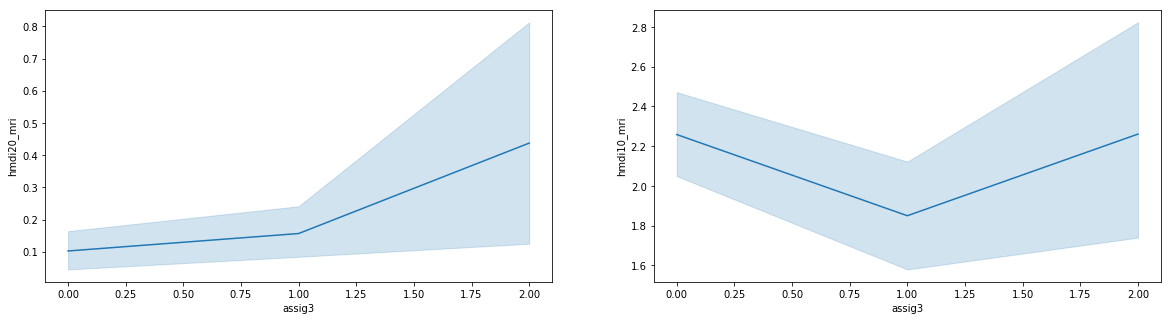

In [102]:
fig=plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
sns.lineplot(y='hmdi20_mri',x='assig3',data=clin, palette='bright')
plt.subplot(1,2,2)
sns.lineplot(y='hmdi10_mri',x='assig3',data=clin, palette='bright')
plt.show()

In [27]:
with open((mdd_datadir + sets[0] + '_ctrl.csv'), "r") as f:
    mdd_ctrl_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
with open((all_savedir + sets[0] + '_ctrl.csv'), "r") as f:
    all_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
thick_v = np.linspace(68, 67 + 68, 68).astype(int)
subc_v = np.append(np.linspace(137, 143, 7), np.linspace(145, 151, 7)).astype(int)
Tclabels = labels[np.concatenate([thick_v, subc_v])]

NameError: name 'labels' is not defined

In [25]:
plot_sig_against_norm( Tclabels, all_Tc[np.where(sampleidx==1)[0],:], mdd_ctrl_Tc)

no significant differences between samples


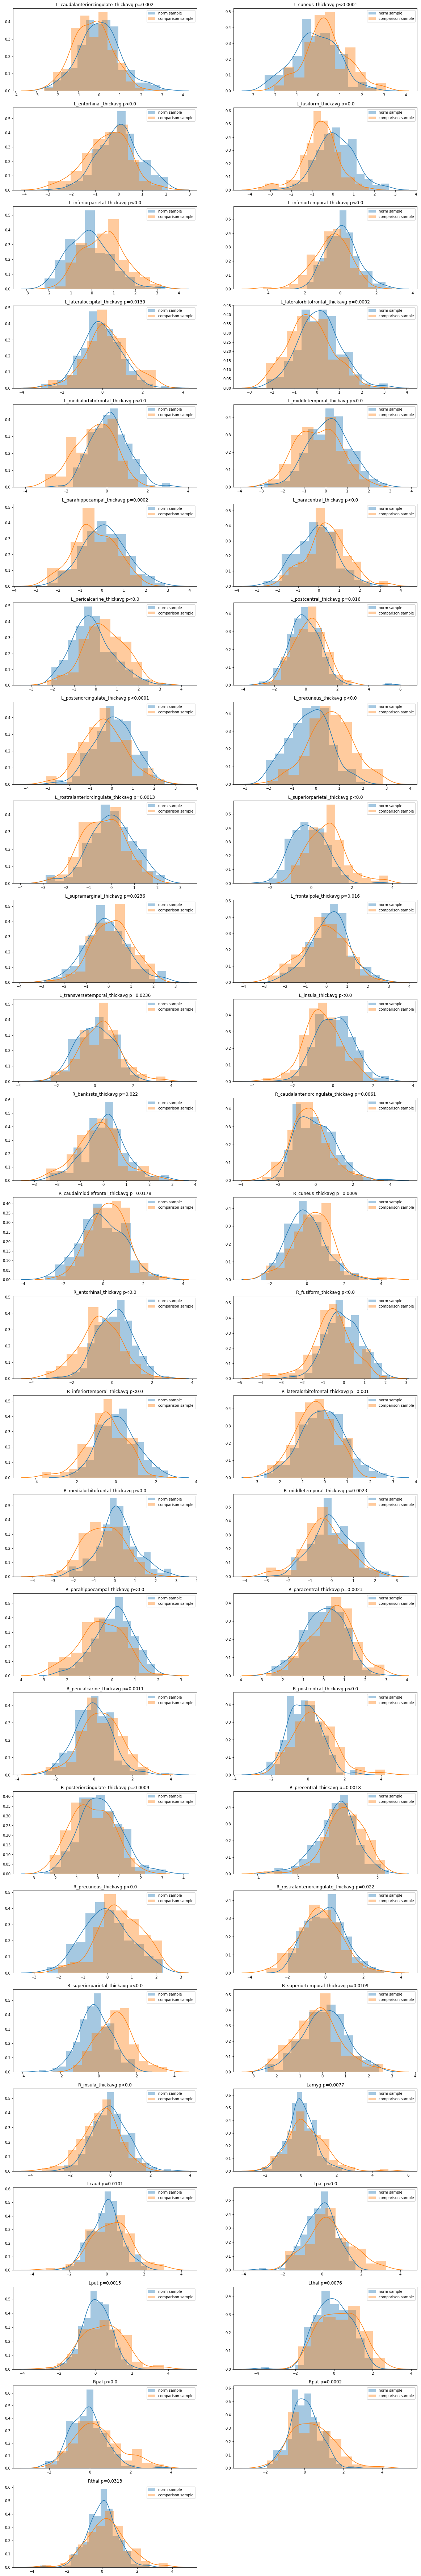

In [26]:
plot_sig_against_norm( Tclabels, all_Tc[np.where(sampleidx==1)[0],:], mdd_ctrl_Tc[np.where(clusassigmdd3==1)[0],:])

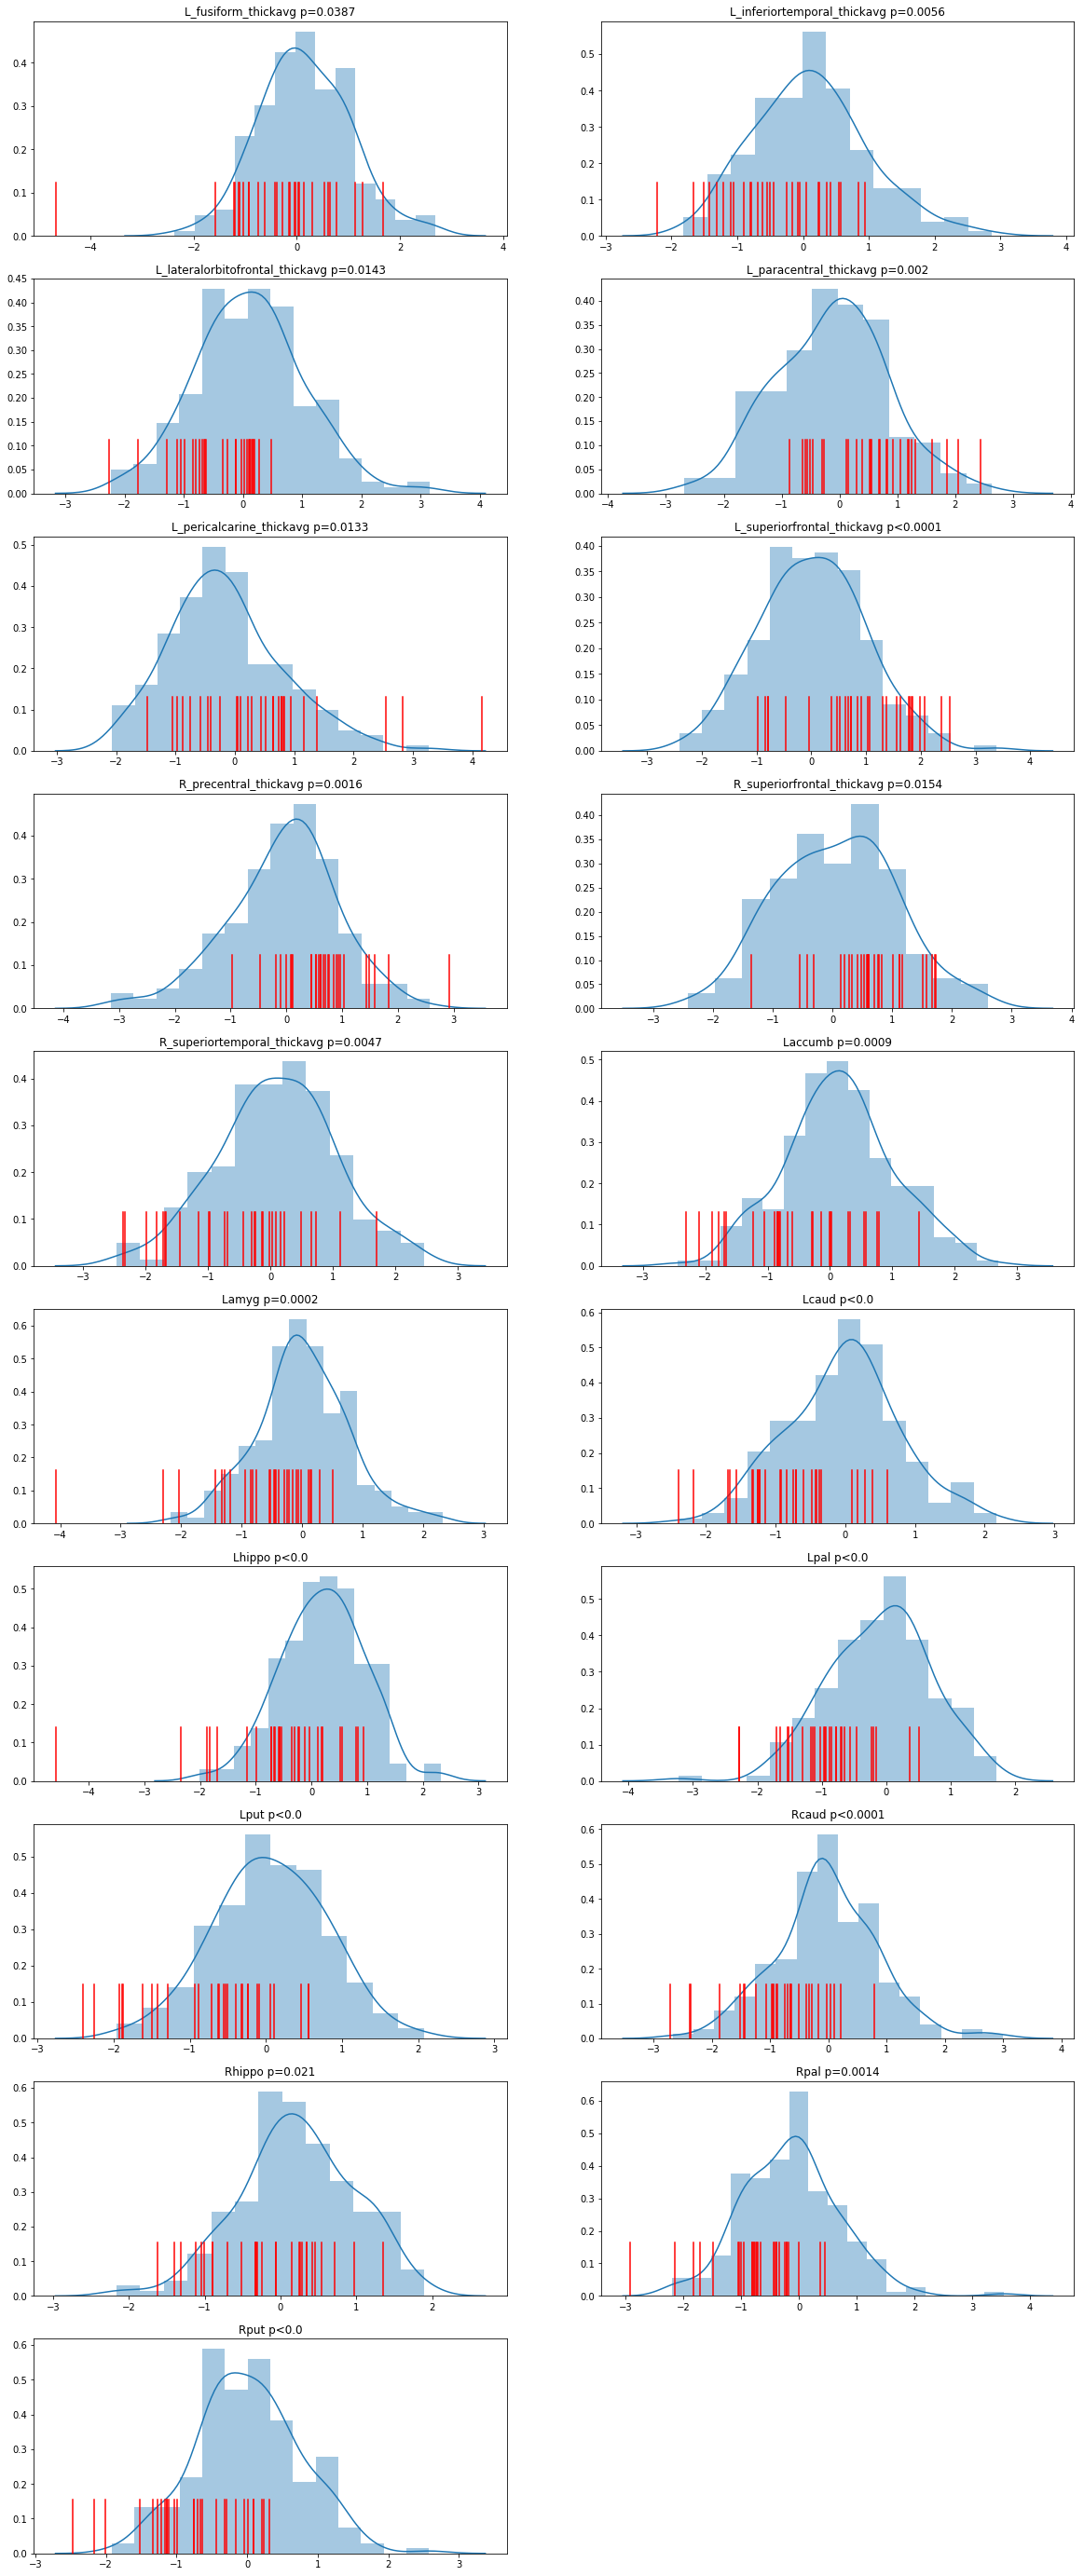

In [27]:
plot_sig_against_norm( Tclabels, all_Tc[np.where(sampleidx==1)[0],:], mdd_ctrl_Tc[np.where(clusassigmdd3==2)[0],:])

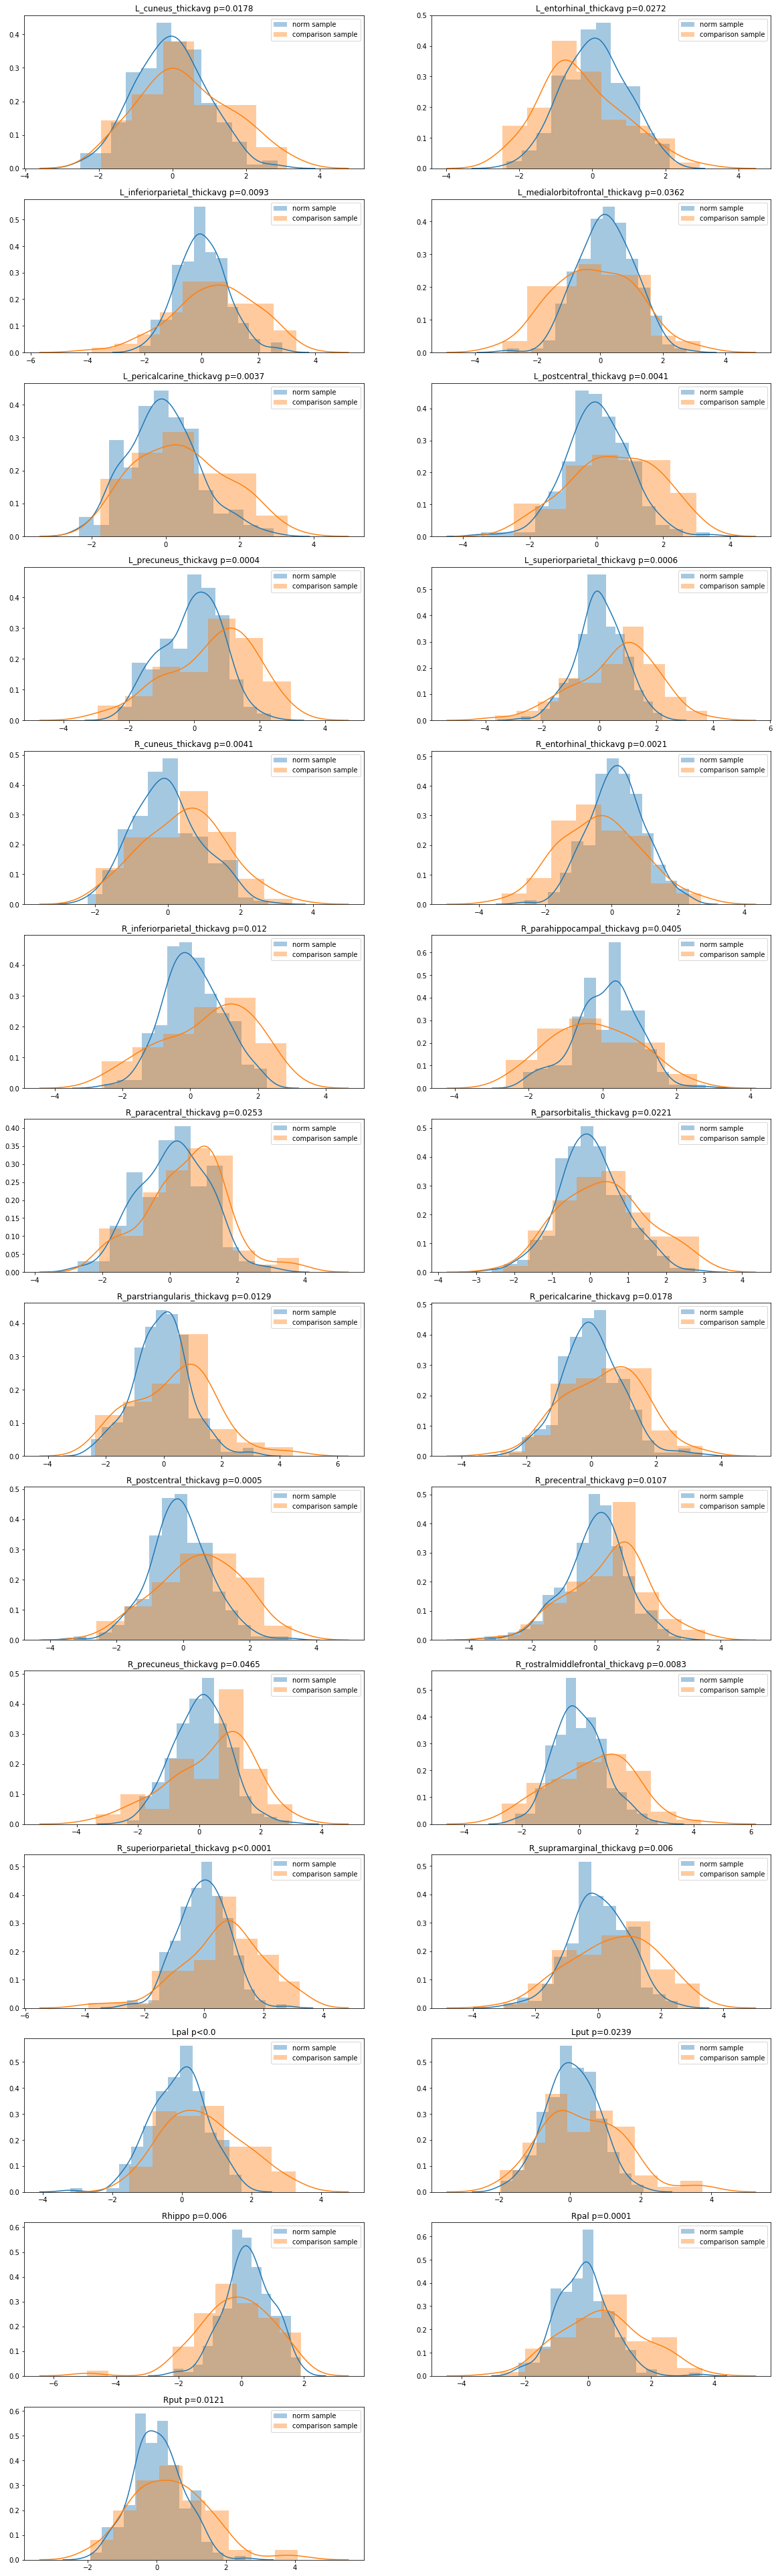

In [33]:
plot_sig_against_norm( Tclabels, all_Tc[np.where(sampleidx==1)[0],:], mdd_ctrl_Tc[np.where(clusassigmdd>0)[0],:])

In [32]:
plot_sig_against_norm( Tclabels, all_Tc[np.where(sampleidx==1)[0],:], mdd_ctrl_Tc[np.where(clusassigmdd==0)[0],:])

no significant differences between samples


In [35]:
# save averages for cluassigmdd
savetxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/set0_cortthinclus_mddavg.csv', np.mean(mdd_ctrl_Tc[np.where(clusassigmdd==1)[0],:],axis=0), delimiter=',', header='header')
savetxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/set0_cortthickclus_mddavg.csv', np.mean(mdd_ctrl_Tc[np.where(clusassigmdd==2)[0],:],axis=0), delimiter=',', header='header')

In [71]:
clusassigall=np.loadtxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_all_s0_c4.csv')
conmat = contingency_matrix(clusassigall, sampleidx)
print(conmat)
#['ctrl','mdd','bp','ad','hunt','scz','mci']

[[201 374  19  17   9  34  25]
 [  1   1   0   8  11   0   1]
 [ 10  23   1   1   0   2   2]]


In [77]:
X=mdd_ctrl_Tc[np.where(clusassigmdd>0)[0],:]
Y=clusassigmdd[np.where(clusassigmdd>0)[0]]
f1, prec, rec, accuracy, pred, beta, intercept = classifierMR(X,Y,X,Y,1000)

In [62]:
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

def new_multiclassifCV(X, y, ncv, nbag):
    kf = KFold(n_splits=ncv, shuffle=True, random_state=None)
    allbetas = []
    allitcpt = []

    ug = np.unique(y)
    if len(ug)==2:
        meanbetas = np.full([ncv,X.shape[1]],np.nan)
        meanitcpt = np.full([ncv],np.nan)
    else:
        meanbetas = np.full([ncv,X.shape[1], len(ug)], np.nan)
        meanitcpt = np.full([ncv,len(ug)], np.nan)

    fold=-1
    for train_index, test_index in kf.split(X):
        fold+=1

        clf = LogisticRegression(random_state=0, multi_class='ovr').fit(X[train_index, :],
                                                                        y[train_index],
                                                                        )

        if nbag==1:
            betas2add = clf.coef_.T
            itcpt2add = clf.intercept_
        else:
            bag_regr = BaggingClassifier(base_estimator=clf, n_estimators=nbag, max_samples=0.66, max_features=1.0,
                                         bootstrap=True, bootstrap_features=False, oob_score=False,
                                         warm_start=False,
                                         n_jobs=None, random_state=None, verbose=0)
            bag_regr.fit(X[train_index, :], y[train_index])
            
            if len(ug)==2:
                betas_all = np.full([X.shape[1], nbag],np.nan)
                itcpt_all = np.full([nbag],np.nan)
                for bag in range(nbag):
                    betas_all[:, bag] = bag_regr.estimators_[bag].coef_[0]
                    itcpt_all[bag] = bag_regr.estimators_[bag].intercept_
                meanbetas[fold,:] = np.nanmedian(betas_all, axis=1)
                meanitcpt[fold] = np.nanmedian(itcpt_all)
            else:
                betas_all = np.full([X.shape[1], len(ug), nbag], np.nan)
                itcpt_all = np.full([len(ug), nbag], np.nan)
                for bag in range(nbag):
                    for c in range(len(ug)):
                        betas_all[:, c, bag] = bag_regr.estimators_[bag].coef_[c]
                        itcpt_all[c, bag] = bag_regr.estimators_[bag].intercept_[c]
                meanbetas[fold,:,:] = np.nanmedian(betas_all, axis=2)
                meanitcpt[fold,:] = np.nanmedian(itcpt_all, axis=1)


    return np.nanmedian(meanbetas, axis=0), np.nanmedian(meanitcpt, axis=0)

def asscert(trainproba):
    assig = np.full([trainproba.shape[0]],np.nan)
    cert = np.full([trainproba.shape[0]],np.nan)
    for n in range(trainproba.shape[0]):
        assig[n]=np.where(trainproba[n,:]==np.max(trainproba[n,:]))[0]
        cert[n]=trainproba[n,assig[n].astype(int)]
    return assig, cert

In [111]:
with open((mdd_datadir + sets[0] + '_ctrl.csv'), "r") as f:
    mdd_ctrl_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
clusassigmdd=np.loadtxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_mddctrl_s0_c3.csv')

X=mdd_ctrl_Tc#[np.where(clusassigmdd>0)[0],:]
Y=clusassigmdd#[np.where(clusassigmdd>0)[0]]
betas, itcpt = new_multiclassifCV(X, Y, 5, 1000)

In [118]:
with open((all_savedir + sets[0] + '_ctrl.csv'), "r") as f:
    all_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
savedir = '/Users/lee_jollans/Projects/clustering_pilot/IXI/'
with open((savedir + 'IXI2_Tc.csv'), "r") as f:
    ixi_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
    
ibetas=np.append(np.expand_dims(itcpt, axis=1).T, betas,axis=0)
trainprob1, testprobmdd1 = get_proba(X, Y, ibetas, mdd_ctrl_Tc)
trainprob1, testproball1 = get_proba(X, Y, ibetas, all_Tc)
trainprob1, testprobixi1 = get_proba(X, Y, ibetas, ixi_Tc)
trainprob1, testproballhc1 = get_proba(X, Y, ibetas, all_Tc[np.where(sampleidx==1)[0],:])

assigmdd1, certmdd1 = asscert(trainprob1)
assigall1, certall1 = asscert(testproball1)
assigixi1, certixi1 = asscert(testprobixi1)
assigallhc1, certallhc1 = asscert(testproballhc1)

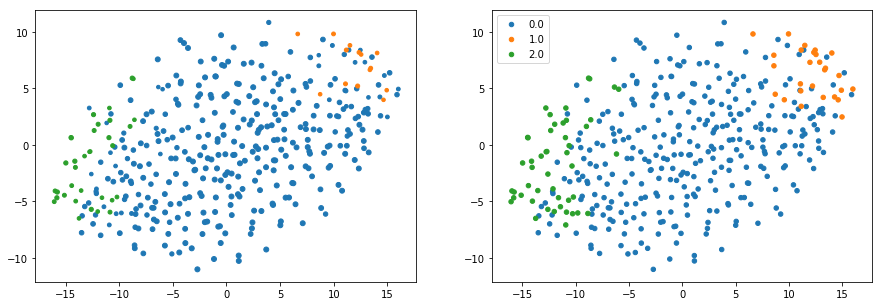

In [115]:
assigmdd, certmdd = asscert(trainprob)
mdd_ctrl_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(mdd_ctrl_Tc)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
colorscatter(mdd_ctrl_tsne, assigmdd1, certmdd1*5, ax1, 1)
colorscatter(mdd_ctrl_tsne, clusassigmdd, np.ones(398)*4, ax2, 1)
plt.show()

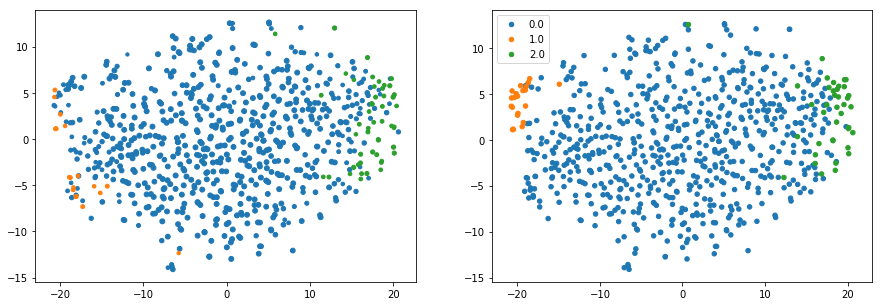

In [116]:
clusassigall=np.loadtxt('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/cluslabels_all_s0_c4.csv')

assigall, certall = asscert(testprob)
all_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(all_Tc)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
colorscatter(all_tsne, assigall1, certall1*5, ax1, 1)
colorscatter(all_tsne, clusassigall, np.ones(740)*4, ax2, 1)
plt.show()

In [119]:
print(np.nanmean(trainprob1,axis=0))
print(np.nanmean(testprobixi1,axis=0))
print(np.nanmean(testproball1,axis=0))
print(np.nanmean(testproballhc1,axis=0))

[0.83236655 0.06417969 0.10345377]
[0.83454796 0.05805405 0.10739799]
[0.83338524 0.06230584 0.10430891]
[0.86453546 0.03469549 0.10076905]


In [145]:
clin['no cluster likelihood']=trainprob1[:,0]
clin['Cortical thinning cluster likelihood']=trainprob1[:,1]
clin['Cortical thickening cluster likelihood']=trainprob1[:,2]

In [164]:
for n in range(3):
    corrwithnans(clin['brainage'].to_numpy(),trainprob1[:,n])
    corrwithnans(clin['brainPAD'].to_numpy(),trainprob1[:,n])

N=323, r=0.07534907281533786
N=323, r=-0.2418589468161143
N=323, r=0.2605371146987132
N=323, r=-0.21570666832909302
N=323, r=-0.22292749911021653
N=323, r=0.3686795867937085


In [165]:
Xinit = pd.read_csv(r'/Users/lee_jollans/Projects/MARS_GSK_project/data/alldatacollect/controldata.csv',header=None);
ctrlbrainage = np.vstack(Xinit.values[1:,162]).astype(np.float)
ctrlbrainpad = np.vstack(Xinit.values[1:,157]).astype(np.float)-np.vstack(Xinit.values[1:,162]).astype(np.float)
for n in range(3):
    corrwithnans(ctrlbrainage,testproballhc1[:,n])
    corrwithnans(ctrlbrainpad,testproballhc1[:,n])

N=207, r=0.11599699458072084
N=207, r=-0.18540348423937283
N=207, r=0.20377658253040987
N=207, r=-0.18321767066500894
N=207, r=-0.20429322201179814
N=207, r=0.262276459176257


In [142]:
# add all the probabilities etc to a dataframe
dfproba = pd.DataFrame({}, columns=['dataset', 'label', 'assig', 'certmax', 'likelihood', 'cluster'])
for c in range(3):
    df1= pd.DataFrame({'dataset': ['mdd']*398,
                       'label': ['mdd']*398,
                       'assig': assigmdd1,
                       'certmax': certmdd1,
                       'likelihood': trainprob1[:,c],
                       'cluster': np.ones(shape=[398])*c},
                      columns=['dataset', 'label', 'assig', 'certmax', 'likelihood', 'cluster'])
    dfproba = dfproba.append(df1)
    df2= pd.DataFrame({'dataset': ['ixi']*544,
                       'label': ['hc']*544,
                       'assig': assigixi1,
                       'certmax': certixi1,
                       'likelihood': testprobixi1[:,c],
                       'cluster': np.ones(shape=[544])*c},
                      columns=['dataset', 'label', 'assig', 'certmax', 'likelihood', 'cluster'])
    dfproba = dfproba.append(df2)
    df3= pd.DataFrame({'dataset': ['all']*212,
                       'label': ['hc']*212,
                       'assig': assigallhc1,
                       'certmax': certallhc1,
                       'likelihood': testproballhc1[:,c],
                       'cluster': np.ones(shape=[212])*c},
                      columns=['dataset', 'label', 'assig', 'certmax', 'likelihood', 'cluster'])
    dfproba = dfproba.append(df3)

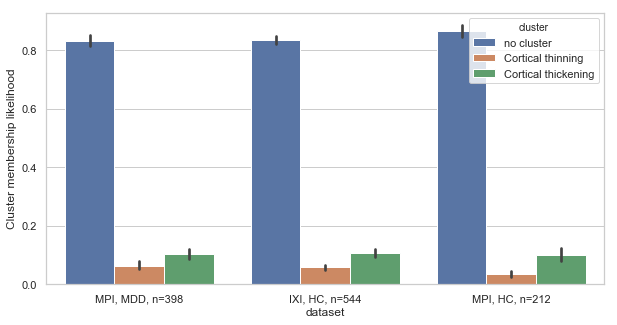

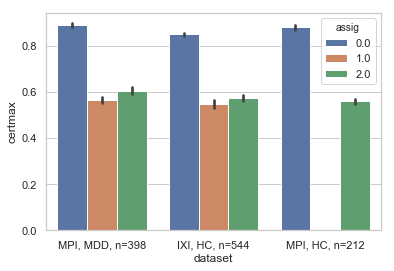

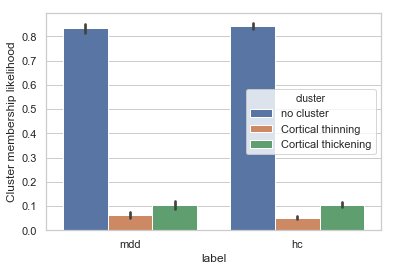

In [143]:
import seaborn as sns
dfproba['Cluster membership likelihood']= dfproba['likelihood']
dfproba['cluster']=dfproba['cluster'].replace({0: 'no cluster',1: 'Cortical thinning',2: 'Cortical thickening'})
dfproba['dataset']=dfproba['dataset'].replace({'mdd': 'MPI, MDD, n=398','ixi': 'IXI, HC, n=544','all': 'MPI, HC, n=212'})

sns.set(style="whitegrid")
fig = plt.figure(figsize=[10,5])
plt.subplot(1,1,1); sns.barplot(x="dataset", y="Cluster membership likelihood",hue='cluster' ,data=dfproba)
plt.show()
ax = sns.barplot(x="dataset", y="certmax",hue='assig' ,data=dfproba)
plt.show()
ax = sns.barplot(x="label", y="Cluster membership likelihood",hue='cluster' ,data=dfproba)
plt.show()

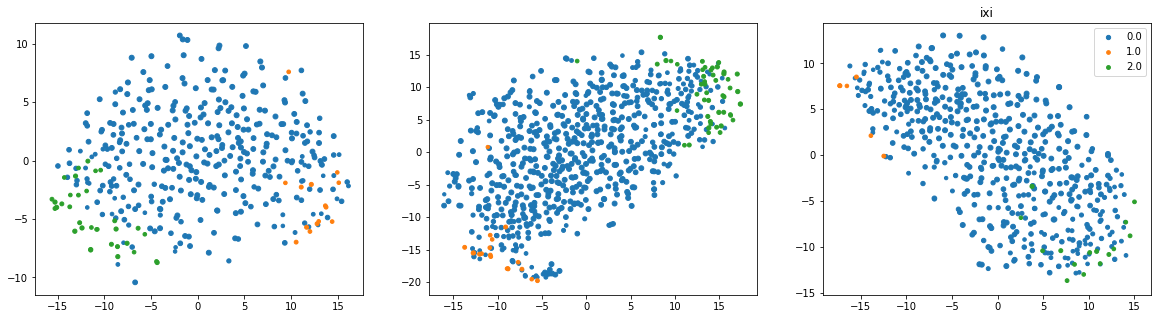

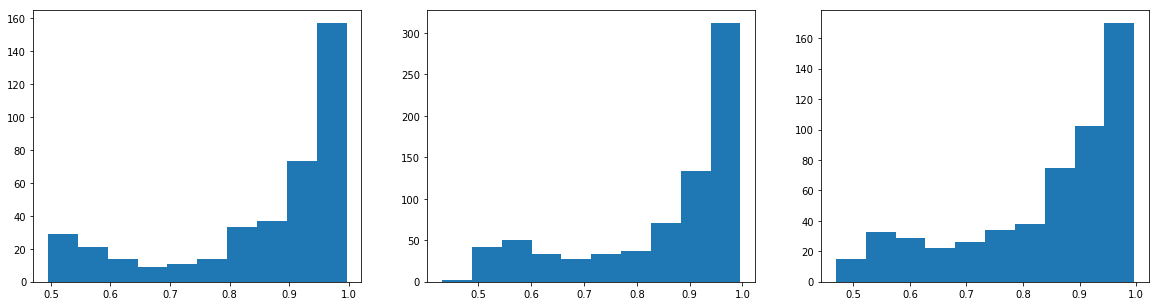

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[20,5])
colorscatter(mdd_ctrl_tsne, assigmdd1, (certmdd1)*5, ax1, 1); plt.title('mdd')
colorscatter(all_tsne, assigall1, (certall1)*5, ax2, 1); plt.title('all')
colorscatter(ixi_tsne, assigixi1, (certixi1)*5, ax3, 1);  plt.title('ixi')
plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[20,5])
ax1.hist(certmdd1)
ax2.hist(certall1)
ax3.hist(certixi1)
plt.show()

In [69]:
print('all controls:' , [len(np.where(assigall[np.where(sampleidx==1)[0]]==i)[0]) for i in range(3)])
print('all MDD:' , [len(np.where(assigall[np.where(sampleidx==2)[0]]==i)[0]) for i in range(3)])
print('all BP:' , [len(np.where(assigall[np.where(sampleidx==3)[0]]==i)[0]) for i in range(3)])
print('all SCZ:' , [len(np.where(assigall[np.where(sampleidx==6)[0]]==i)[0]) for i in range(3)])
print('all MCI:' , [len(np.where(assigall[np.where(sampleidx==7)[0]]==i)[0]) for i in range(3)])
print('all AD:' , [len(np.where(assigall[np.where(sampleidx==4)[0]]==i)[0]) for i in range(3)])
print('all HUNT:' , [len(np.where(assigall[np.where(sampleidx==5)[0]]==i)[0]) for i in range(3)])

#['ctrl','mdd','bp','ad','hunt','scz','mci']

all controls: [204, 0, 8]
all MDD: [351, 11, 36]
all BP: [19, 1, 0]
all SCZ: [32, 0, 4]
all MCI: [26, 0, 2]
all AD: [20, 5, 1]
all HUNT: [18, 2, 0]


In [74]:
# now do just a binary classification 
X=mdd_ctrl_Tc[np.where(clusassigmdd>0)[0],:]
Y=clusassigmdd[np.where(clusassigmdd>0)[0]]
betas2, itcpt2 = new_multiclassifCV(X, Y, 5, 1000)

IndexError: too many indices for array

In [83]:
ibetas=np.expand_dims(np.append(np.expand_dims(itcpt2, axis=1).T, betas2,axis=0),axis=1)
ibetas=np.append(ibetas,ibetas,axis=1)
trainprob, testprobmdd = get_proba(X, Y, ibetas, mdd_ctrl_Tc)
trainprob, testproball = get_proba(X, Y, ibetas, all_Tc)
trainprob, testprobixi = get_proba(X, Y, ibetas, ixi_Tc)
assigmdd2, certmdd2 = asscert(testprobmdd)
assigall2, certall2 = asscert(testproball)
assigixi2, certixi2 = asscert(testprobixi)

In [101]:
print(np.nanmin(certmdd2[np.where(clusassigmdd==1)[0]]))
print(np.nanmin(certmdd2[np.where(clusassigmdd==2)[0]]))

0.7097837145324833
0.7631180337030843


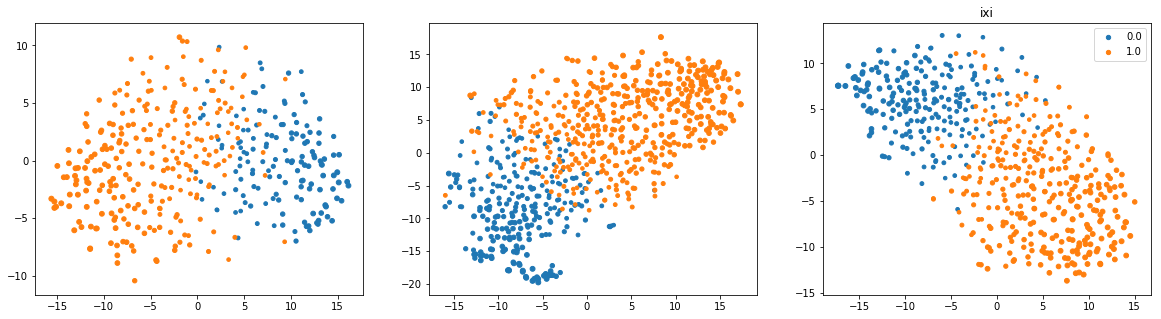

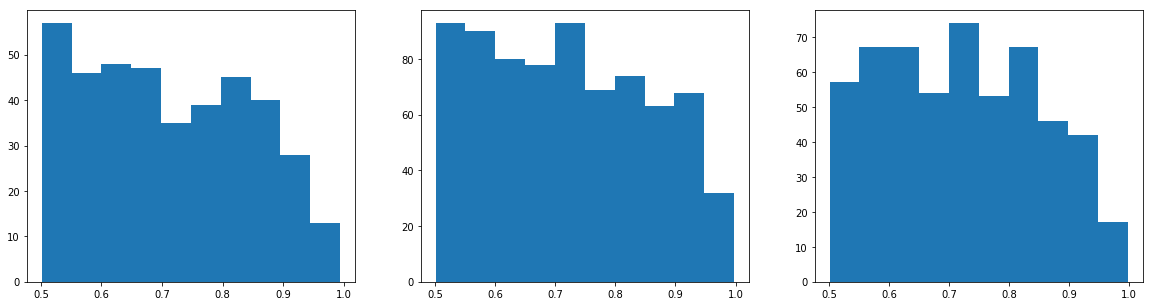

In [87]:
assigmdd2, certmdd2 = asscert(testprobmdd)
assigall2, certall2 = asscert(testproball)
assigixi2, certixi2 = asscert(testprobixi)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[20,5])
colorscatter(mdd_ctrl_tsne, assigmdd2, (certmdd2)*5, ax1, 1); plt.title('mdd')
colorscatter(all_tsne, assigall2, (certall2)*5, ax2, 1); plt.title('all')
colorscatter(ixi_tsne, assigixi2, (certixi2)*5, ax3, 1);  plt.title('ixi')
plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[20,5])
ax1.hist(certmdd2)
ax2.hist(certall2)
ax3.hist(certixi2)
plt.show()

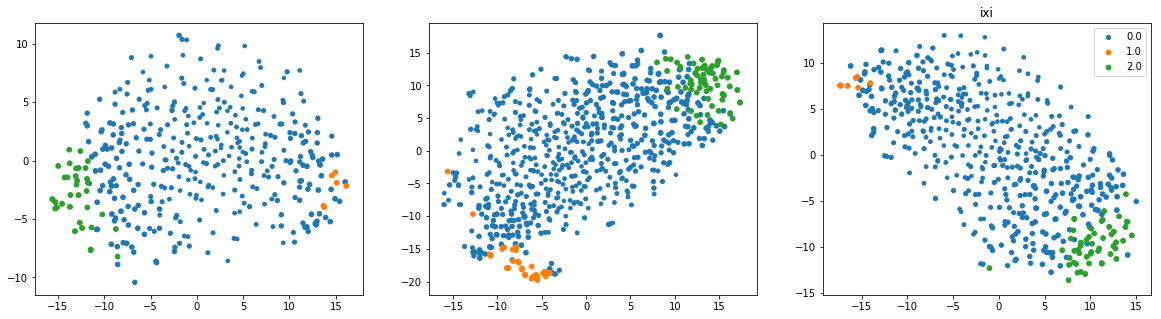

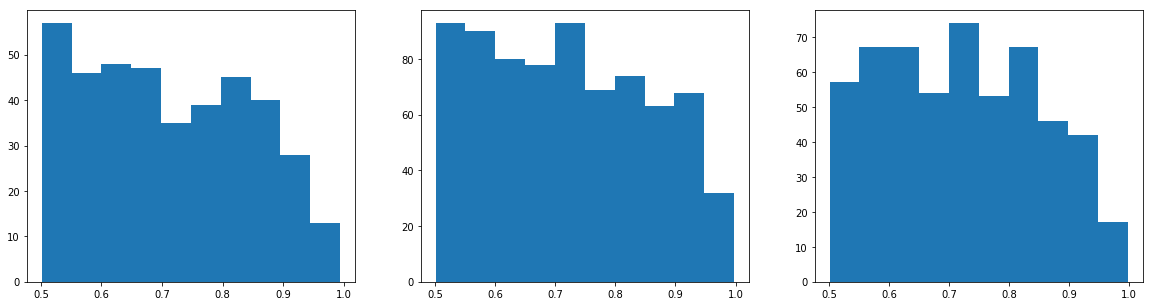

mdd: [358, 6, 34]
all: [644, 31, 65]
ixi: [486, 8, 50]
all controls: [189, 3, 20]


In [104]:
assigmdd2, certmdd2 = asscert(testprobmdd)
assigall2, certall2 = asscert(testproball)
assigixi2, certixi2 = asscert(testprobixi)

limit=.90

assigmdd2=assigmdd2+1
assigmdd2[np.where(certmdd2<limit)[0]]=0
assigall2=assigall2+1
assigall2[np.where(certall2<limit)[0]]=0
assigixi2=assigixi2+1
assigixi2[np.where(certixi2<limit)[0]]=0
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[20,5])
colorscatter(mdd_ctrl_tsne, assigmdd2, (certmdd2)*5, ax1, 1); plt.title('mdd')
colorscatter(all_tsne, assigall2, (certall2)*5, ax2, 1); plt.title('all')
colorscatter(ixi_tsne, assigixi2, (certixi2)*5, ax3, 1);  plt.title('ixi')
plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[20,5])
ax1.hist(certmdd2)
ax2.hist(certall2)
ax3.hist(certixi2)
plt.show()

print('mdd:' , [len(np.where(assigmdd2==i)[0]) for i in range(3)])
print('all:' , [len(np.where(assigall2==i)[0]) for i in range(3)])
print('ixi:' , [len(np.where(assigixi2==i)[0]) for i in range(3)])
print('all controls:' , [len(np.where(assigall2[np.where(sampleidx==1)[0]]==i)[0]) for i in range(3)])

In [92]:
allY=all_Tc.dot(beta)+intercept
print([np.nanmean(allY[np.where(sampleidx==i+1)]) for i in range(7)])
#['ctrl','mdd','bp','ad','hunt','scz','mci']

[0.5276884141788039, 0.5756573240786923, 0.14181689521821755, -4.748129772686159, -9.190704359655564, 0.2424570167950015, -0.1809618093138611]


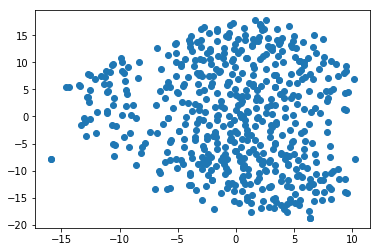

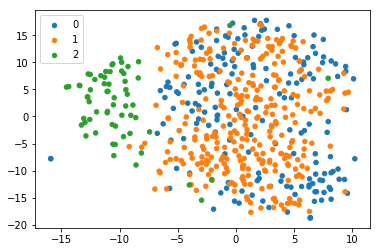

In [4]:
# tsne to check for henkel
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import sys
sys.path.append('/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering')
from cv_clustering.utils import colorscatter

savedir = '/Users/lee_jollans/Projects/clustering_pilot/IXI/'
with open((savedir + 'IXI_Tc.csv'), "r") as f:
    ixi_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
ixi_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(ixi_Tc)
plt.scatter(ixi_tsne[:,0],ixi_tsne[:,1]); plt.show()

savedir = '/Users/lee_jollans/Projects/clustering_pilot/IXI/'
ixi_sitelist = pd.read_csv(savedir + '/SiteIXI_Lee.txt', delimiter = '\t')
s3 = pd.read_csv('/Users/lee_jollans/Projects/clustering_pilot/ixi_s3_outliers_nans_removed.csv')
s3 = s3.rename(columns={"eTIV": "ICV", "Ethnicity": "site_pheno"})
res=s3.merge(ixi_sitelist, left_on='ALL_IDs', right_on='SubjID')
sitesort = res['SITE'].to_numpy()

fig=plt.figure()
ax=plt.subplot(1,1,1)
colorscatter(ixi_tsne, sitesort, np.ones(shape=[544,1])*4, ax, 1)

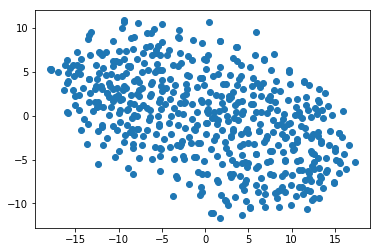

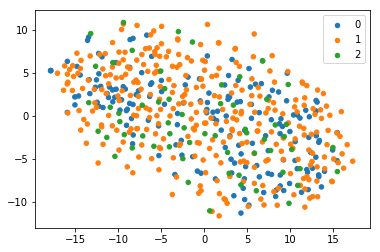

In [5]:
savedir = '/Users/lee_jollans/Projects/clustering_pilot/IXI/'
with open((savedir + 'IXI2_Tc.csv'), "r") as f:
    ixi_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
ixi_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1, learning_rate=2, n_iter=1000).fit_transform(ixi_Tc)
plt.scatter(ixi_tsne[:,0],ixi_tsne[:,1]); plt.show()

savedir = '/Users/lee_jollans/Projects/clustering_pilot/IXI/'
ixi_sitelist = pd.read_csv(savedir + '/SiteIXI_Lee.txt', delimiter = '\t')
s3 = pd.read_csv('/Users/lee_jollans/Projects/clustering_pilot/ixi_s3_outliers_nans_removed.csv')
s3 = s3.rename(columns={"eTIV": "ICV", "Ethnicity": "site_pheno"})
res=s3.merge(ixi_sitelist, left_on='ALL_IDs', right_on='SubjID')
sitesort = res['SITE'].to_numpy()

fig=plt.figure()
ax=plt.subplot(1,1,1)
colorscatter(ixi_tsne, sitesort, np.ones(shape=[544,1])*4, ax, 1)

In [ ]:
# ixi problem solved! now apply the mdd classifier to them
